# Part 5 - project

### Group Members: Roy Madpis, Rawaa Makhoul, Alexandra Fatyeyeva

*Note: This python file proceeds the work we did on part 2 - in R

## <font color = royalblue > Introduction: </font>

### In this Python Script we build the Peer To Peer Lending Model
The model classifies loans into 2 classes:

+ class "0" = The loan will have realized return that is **higher than 2%**
+ class "1" = The loan will have realized return that is **Not higher than 2%**


### We build the model in 4 different steps

1. **Loading the data:** loading the cleaned table (Continuing stage 2)


2. **Preprocessing:**
    - Creating new features - Feature engineering
    - Selecting columns to use in the model
    - Dealing with NAs (if needed)
    - Dealing with outliers (if needed)
    - One Hot Key encoding
    - Last filtering of columns
    - Train-Test Split (needs to be done before scaling)
    - Scaling - normalizing the data
    
    
3. **Model selection:** Building a XGBoost model
    
    
4. **Scoring:**
    + **For Classification models:**
        - Accuracy, Precision, Recall, F1 Score + NPV (Negative predictive value)
        - ROC Curve + AUC
    
    - **Cross validation** - In order to make sure our results are valid and weren't influenced by a specific test set, we built a function that enables performing cross vaildation and get the min, max, mean and sd of multiple metrices.


### Notice that we also performed:

+ **Feature Selection**
+ **Parameter Optimization**

For convenience, the code that we used for those will be pesented in the end of the script

#  Step 1: <font color = forestgreen >Loading the Data: </font> 

In [1]:
#pip install -U scikit-learn
#pip install mlxtend
#pip install xgboost

import numpy as np
import pandas as pd
import csv
import random
import time
import datetime
import os

import seaborn as sns
import warnings
import re #regular expresssion regex 
from sklearn.model_selection import train_test_split
from itertools import islice
from statistics import mean, stdev

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, normalize, Normalizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn. metrics import confusion_matrix

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import KFold #for K folds in cross_val_RAR
from statsmodels.stats.weightstats import DescrStatsW #for weighted sd of realized_return

#Feature Selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#Parameter Optimization:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV

import seaborn as sns

warnings.filterwarnings('ignore')

**Reading the clean table:** The clean was done using the cleaning function we built in R (see part 2).

**Note:** The cleaning includes dealind with NAs, Outliers, changing values, but it doesn't remove columns (only remove the "url" column). The reason for that is: we wish to try using columns, that in part 2 we decided to filter, and perform several cleaning methods (such as dealing with NAs and outliers).

In [2]:
#Reading the clean table
df_2019_clean = pd.read_csv("loan_2019_All_clean_python.csv", encoding='latin-1')

#lets save the original clean table in a variable - df_2019_clean_0 so we can always access it.
df_2019_clean_0 = df_2019_clean.copy()

#  Step 2: <font color = forestgreen >Preprocessing: </font> 

In [3]:
df_2019_clean_2_1 = df_2019_clean_0.copy()

## 2.1 : <font color = seagreen > Preprocessing -  Feature engineering: </font>

In this part we will **Build** new columns from existing ones

### New target column: realized return > 2%?
We wish to create a new **target column** that will hold 2 categories: higher_than_2% OR smaller_than_2%
If the realized return of a loan is higher than 2% => than the loan's value in this column will be: higher_than_2%
Otherwise it will have the value: smaller_than_2%

In [4]:
df_2019_clean_2_1["realized_return_2%"] = np.where(df_2019_clean["realized_return"] > 2, "higher_than_2%", "smaller_than_2%")

### New column: Percent of Rev Acc
We wish to create a new column that will be the quotient of num_op_rev_tl and open_acc

In [5]:
df_2019_clean_2_1['Percent of Rev Acc'] = df_2019_clean_2_1['num_op_rev_tl'] / (df_2019_clean_2_1['open_acc'])
#display(df_2019_clean_2_1[['Percent of Rev Acc', "id"]])

### New column: average_limit_in_bankcard
We wish to create a new column that will be the quotient of total_bc_limit and num_bc_tl

In [6]:
#"num_bc_tl" = Number of bankcard accounts ; "total_bc_limit"
df_2019_clean_2_1['average_limit_in_bankcard'] = df_2019_clean_2_1['total_bc_limit'] / (df_2019_clean_2_1['num_bc_tl'])

### New column: fico_range_high2
We wish to create a new column that will be the product of fico_range_high with itself.

In [7]:
df_2019_clean_2_1["fico_range_high2"] = df_2019_clean_2_1['fico_range_high'] * (df_2019_clean_2_1['fico_range_high'])

### New column: total_bal_il_divided_num_il_tal

We wish to create a new column that will be the quotient of total_bal_il and num_il_tl

+ **total_bal_il** = Total current balance of all installment accounts
+ **num_il_tl** = Number of installment accounts


In [8]:
df_2019_clean_2_1["total_bal_il_divided_num_il_tal"] = df_2019_clean_2_1['total_bal_il'] / (df_2019_clean_2_1['num_il_tl'])

### New column: month_issue_d
We wish to create a new column that will contain the month of the issue date:

In [9]:
#df['month'] = pd.DatetimeIndex(df['birth_date']).month
df_2019_clean_2_1["month_issue_d"] = pd.DatetimeIndex(df_2019_clean_2_1["issue_d"]).month

In [10]:
#df_2019_clean_2_1["month_issue_d"].unique()
#df_2019_clean_2_1[["issue_d","month_issue_d"]]

### New column: prop_open_acc_outof_total_acc
We wish to create a new column that will be the quotient of open_acc and total_acc
+ **open_acc** = The number of open credit lines in the borrower's credit file.
+ **total_acc** = The total number of credit lines currently in the borrower's credit file

In [11]:
#open_acc = The number of open credit lines in the borrower's credit file.
#total_acc = The total number of credit lines currently in the borrower's credit file
df_2019_clean_2_1['prop_open_acc_outof_total_acc'] = df_2019_clean_2_1['open_acc'] / (df_2019_clean_2_1['total_acc'])

### lets unite groups in emp_length
In fact we will collapse the different levels into 2 levels:
1. emp_length 5 years or less
2. emp_length 6 years or above


In [12]:
df_2019_clean_2_1.emp_length = np.where( df_2019_clean_2_1.emp_length.isin(["< 1 year","1 year","2 years","3 years","4 years", '5 years']),    "5 or lower",   df_2019_clean_2_1.emp_length) 
df_2019_clean_2_1.emp_length = np.where( df_2019_clean_2_1.emp_length.isin(["6 years","7 years","8 years","9 years", '10+ years']),    "6 or higher",   df_2019_clean_2_1.emp_length) 


In [13]:
#Group by loan status and realized_return_2%:
df_2019_clean_2_1.groupby(by = ["loan_status", "realized_return_2%"]).count().iloc[0:, 0:1]

Unnamed: 0
loan_status realized_return_2%            
Charged Off higher_than_2%            1432
            smaller_than_2%          46358
Fully Paid  higher_than_2%          187942
            smaller_than_2%          29584

##  <font color = blueviolet > Generating the baseline data - grades </font>

In this part we wish to understand - what would have been our weighted average realized return and standard deviation if we invested in all the loans of a certain grade.

**Note:** The weights is "funded_amnt_inv" and the values are from column "realized_return"

We wish to get 3 important values:
1. Calculating the **weighted average realized return by grades** (weight = funded_amnt_inv)
2. Calculating the **standard deviation of the realized return by grades** (weight = funded_amnt_inv)
3. **Number of loans** in each grade

Those will help us understand the performance of a "baseline" model that invests only by the given grades

In [14]:
#Generating Baseline - grades data
weighted_avergae_grades = df_2019_clean_2_1.groupby(by = ["grade"]).apply(lambda x: np.average(x["realized_return"], weights=x["funded_amnt_inv"]))
weighted_avergae_sd = df_2019_clean_2_1.groupby(by = ["grade"]).apply(lambda x: DescrStatsW(x["realized_return"], weights=x["funded_amnt_inv"], ddof=0).std)
number_of_loans = df_2019_clean_2_1.groupby(by = ["grade"]).size()

baseline_grades = weighted_avergae_grades.to_frame(name = "weighted_average")
baseline_grades["weighted SD"] = weighted_avergae_sd
baseline_grades["Number of Loans"] = number_of_loans

#The weighted average of the realized return of the ALL the loans:
weighted_average_realized_return_all = np.average(df_2019_clean_2_1["realized_return"], weights=df_2019_clean_2_1["funded_amnt_inv"])
#The weighted standard deviation of the realized return All the loans:
weighted_avergae_sd_all = DescrStatsW(df_2019_clean_2_1["realized_return"], weights=df_2019_clean_2_1["funded_amnt_inv"], ddof=0).std
#The Total number of loans:
Total_loans_all = df_2019_clean_2_1.shape[0]

#Df summarizing the weighted average and sd of the realized return and number of loans:
df_to_baseline_all = pd.DataFrame([[weighted_average_realized_return_all,weighted_avergae_sd_all,Total_loans_all]],
                        columns = ["weighted_average","weighted SD", "Number of Loans"],
                            index = ["Total All loans Together"])
    
baseline_grades = baseline_grades.append(df_to_baseline_all)

baseline_grades_original = baseline_grades.copy()
display(baseline_grades_original)

,weighted_average,weighted SD,Number of Loans
A,1.861573,4.514966,56753
B,1.532950,7.149496,92005
C,0.798874,9.438672,74610
D,-0.194200,11.545009,30543
E,-1.022335,13.340783,8798
F,-2.109506,14.559178,2114
G,-3.628924,15.255247,493
Total All loans Together,1.076391,8.414820,265316


## 2.2 : <font color = seagreen > Preprocessing - Selecting columns to use: </font> 
In this part we will **Filter** columns that we don't want to use in our model

In [15]:
columns_not_needed = ["member_id", "funded_amnt",
                        "emp_title", "verification_status",
                        "pymnt_plan", "term", "desc","title", "zip_code",
                        "fico_range_low", "mths_since_last_delinq",
                        "mths_since_last_record","out_prncp","out_prncp_inv",
                        "total_pymnt", "total_rec_prncp","total_rec_int",
                        "total_rec_late_fee", "recoveries",
                        "collection_recovery_fee","last_pymnt_amnt", "next_pymnt_d",
                        "last_credit_pull_d", "last_fico_range_high",
                        "last_fico_range_low", "mths_since_last_major_derog",
                        "policy_code", "annual_inc_joint", "dti_joint",
                        "verification_status_joint", "tot_coll_amt",
                        "mths_since_rcnt_il",
                        "avg_cur_bal",
                        "mths_since_recent_bc_dlq", "mths_since_recent_inq",
                        "mths_since_recent_revol_delinq",
                        "num_tl_120dpd_2m", "num_tl_30dpd",
                      "revol_bal_joint",
                        "sec_app_fico_range_low", "sec_app_fico_range_high",
                        "sec_app_earliest_cr_line", "sec_app_inq_last_6mths",
                        "sec_app_mort_acc", "sec_app_open_acc",
                        "sec_app_revol_util", "sec_app_open_act_il", 
                        "sec_app_num_rev_accts", "sec_app_chargeoff_within_12_mths",
                        "sec_app_collections_12_mths_ex_med",
                        "sec_app_mths_since_last_major_derog", "hardship_flag",
                        "hardship_type", "hardship_reason", "hardship_status",
                        "deferral_term", "hardship_amount", "hardship_start_date",
                        "hardship_end_date", "payment_plan_start_date",
                        "hardship_length", "hardship_dpd", "hardship_loan_status",
                        "orig_projected_additional_accrued_interest",
                        "hardship_payoff_balance_amount",
                        "hardship_last_payment_amount",
                        "debt_settlement_flag", "debt_settlement_flag_date",
                        "settlement_status", "settlement_date", "settlement_amount",
                        "settlement_percentage", "settlement_term","open_il_12m",
                        "last_pymnt_d", "earliest_cr_line", "application_type",
                         "Unnamed: 0",  "issue_d",
                      "realized_return_3", "total_pymnt_inv","il_util", "bc_util",
                        "annual_inc","open_rv_12m", "open_act_il","total_cu_tl", "all_util",
                      "acc_open_past_24mths", 
                      "num_actv_rev_tl","num_rev_tl_bal_gt_0","pct_tl_nvr_dlq",
                          "num_bc_tl", "total_bc_limit", "inq_last_6mths","addr_state",
                     "Quarter", "revol_util", "initial_list_status"]

### Function: <font color = blue > filter_columns: </font>
This function gets 2 arguments:
1. **table** - the table we want to filter columns from
2. **columns_not_needed** - a list of the column names we don't want to use

**Note:**
If the function is asked to filter a certain column that doesn't exist in the given table, it won't explode, it would insert that column name in a list and in the end will show the user all the column names that were asked to filter, however don't exist in the given table.
    
The function **return** the table that was inserted without the columns the were inserted in "columns not needed"

In [16]:
def filter_columns (table, columns_not_needed):
    
    #If the function is asked to filter a certain column that doesn't exist in the given table,
    #It won't explode, it would insert that column name in a list and in the end will show the user all
    #the columns that were asked to filter, however doesn't exist in the given table.
    original_number_of_features = table.shape[1]
    list_cols_problems = []
    
    for column in columns_not_needed:
        if column in table.columns:
            table = table.drop(labels=column, axis = 1)
        else:
            list_cols_problems.append(column)
            
    if len(list_cols_problems) > 0:       
        print("Columns that you asked to filter, however they don't exist in the given table: ")
        for col in list_cols_problems:
            print(col)
        print()
    
    final_number_of_features = table.shape[1] 
    
    print('The given table had %i featues, %i features were filtered and %i are left ' % (original_number_of_features, 
        original_number_of_features-final_number_of_features, final_number_of_features))
        
    return table

In [17]:
df_2019_clean_2_2 = filter_columns(df_2019_clean_2_1, columns_not_needed)

The given table had 161 featues, 99 features were filtered and 62 are left 


In [18]:
#for i in df_2019_clean_2_2.columns:
#    print(i)

## 2.3 : <font color = seagreen > Preprocessing -   Dealing with NAs: </font>

In this part we will **deal** with columns that have NA values.
The method we will use for dealing with NAs:
1. **Deleting rows with NA value** in the column
2. **Replace the NA with other value** (for example the mean / median / mode value)

### Function: <font color = blue > na_count: </font>
This function gets 3 arguments:
1. **df** - the table we want to see how many NAs are in each column 
2. **display_rows_with_nas** - a boolean. If True, than for columns with NAs, display the rows with NA value in the column. **default = False**
3. **show_all_columns** - a boolean. If True, than in the output print also the columns with 0 NAs. **default = False**

This function prints the number of NAs in:
  + All the columns (if show_all_columns = True)
  + Only the columns with NAs (at list 1 NA or more) (**default**)

In [19]:
def na_count(df, display_rows_with_nas = False, show_all_columns = False):
    for col in df.columns:
        nas_col = df[df[col].isna()]
        
        if show_all_columns == True:
            print("Column {} has {} missing values. \n".format(col, nas_col.shape[0]))
        elif nas_col.shape[0] > 0:
             print("Column {} has {} missing values. \n".format(col, nas_col.shape[0]))
                
        if nas_col.shape[0] > 0 and display_rows_with_nas == True:
            print("The rows that has NA:")
            display(nas_col)
        
        if show_all_columns == True:
            print("--------------------------------------------\n")

### Function: <font color = blue > dealing with NAs: </font>
This function gets 3 arguments:
1. **df** - the table we want to deal with its NAs
2. **columns_to_filter_all** - a list of columns that we wish to filter all of their NAs. If you insert columns that don't exist in *df*, then the function won't collapse, it will output the names of the columns that were not found and thus weren't dealt
3. **columns_to_replace_with_mean** - a list of columns that we wish to replace their NA value with the mean of the column.
**Note**: If one or more of the columns in the list won't be a column with numbers, the function will  **<font color = red > collapse </font>**
4. **drop_all** - a boolean. If True, then delete **all the rows with NAs for all the columns** in *df*, **default = False**

This function **returns** the input table after dealing with its NAs

In [20]:
def dealing_with_NAs (df, columns_to_filter_all=[], columns_to_replace_with_mean=[], drop_all = False):
    original_number_of_rows = df.shape[0]
    columns = df.columns
    
    if drop_all == True:
        df = df.dropna()
    
    #Dealing with NAs - method 1: filter all the rows with NA value in certain given columns
    list_cols_problems = []
    if drop_all == False and len(columns_to_filter_all) >0 : 
        for column in columns_to_filter_all:
            if column in columns:
                df = df.dropna(subset = [column], inplace=False)
            else:
                list_cols_problems.append(column)

        if len(list_cols_problems) > 0:       
            print("Columns that you asked to filter ALL of their NAs, however they don't exist in the given table: ")
            for col in list_cols_problems:
                print(col)
            print()
    
    
    #Dealing with NAs - method 2: Replace all the rows with NA value with the **mean value of the column**
    list_cols_problems2 = []
    if drop_all == False and len(columns_to_replace_with_mean) >0: 
        for column in columns_to_replace_with_mean:
            if column in columns:
                values = {column: np.mean(df[column])}
                df = df.fillna(value = values)
                #df[column] = df.column.fillna(np.mean(df.column), inplace = False)
            else:
                list_cols_problems2.append(column)

        if len(list_cols_problems2) > 0:       
            print("Columns that you asked to replace their NA value with the MEAN of the column, however they don't exist in the given table: ")
            for col in list_cols_problems2:
                print(col)
            print()
    
    final_number_of_rows = df.shape[0]
    print('The given table had %i rows, %i rows were filtered and %i are left: ' % (original_number_of_rows, 
    original_number_of_rows-final_number_of_rows, final_number_of_rows))
    
    return df

In [21]:
#Nas in the data frame **before** dealing with NAs:
na_count(df_2019_clean_2_2)

Column emp_length has 18879 missing values. 

Column bc_open_to_buy has 3041 missing values. 

Column mo_sin_old_il_acct has 8008 missing values. 

Column mths_since_recent_bc has 2862 missing values. 

Column percent_bc_gt_75 has 3064 missing values. 

Column average_limit_in_bankcard has 755 missing values. 

Column total_bal_il_divided_num_il_tal has 8025 missing values. 



In [22]:
### Dealing wih NAs:
# Here we deal with the NAs:
columns_to_filter_all =[]
columns_to_replace_with_mean =[]
#df_2019_clean_2_3 = dealing_with_NAs(df_2019_clean_2_2, columns_to_filter_all, columns_to_replace_with_mean)
df_2019_clean_2_3 = dealing_with_NAs(df_2019_clean_2_2, drop_all = True)

The given table had 265316 rows, 28301 rows were filtered and 237015 are left: 


In [23]:
#Nas in the data frame **after** dealing with NAs:
na_count(df_2019_clean_2_3)

## 2.4 : <font color = seagreen > Preprocessing -   Dealing with Outliers: </font>

In this part we will **deal** with columns that have Outlier values.
The method we will use for dealing with Outliers:
1. **Deleting rows with Outlier value** in the column


In [24]:
df_2019_clean_2_4 = df_2019_clean_2_3.copy()

## 2.5 : <font color = seagreen > Preprocessing - One Hot Key Encoding: </font>

In this part we will **deal with the categorical columns** - we need to use One Hot Key Encoding

### Function: <font color = blue > dummy_variables: </font>
This function gets 2 arguments:
1. **df** - the table we want to change its categorical variables into one-hot-key
2. **categorical_columms_not_to_use** - a list of columns that we don't want to change them into dummy variables. This is mainly because those can be target variables. **Note:** you must filter those columns before modeling, unless the column is the target variable. If you insert columns that don't exist in *df*, then the function won't collapse, it will output the names of the columns that were not found and thus weren't dealt

This function **returns** the input table after Generating the dummy variables

In [25]:
df_2019_clean_2_5 = df_2019_clean_2_4.copy()

In [26]:
def dummy_variables (df, categorical_columms_not_to_use):
    columns_to_encode = list(df.select_dtypes(include=['object']).columns)
    list_cols_problems = []
    
    for column in categorical_columms_not_to_use:
        if column in columns_to_encode:
            columns_to_encode.remove(column)
        else:
            list_cols_problems.append(column)

    if len(list_cols_problems) > 0:       
        print("Columns that you asked to not encode, however they don't exist in the given table: ")
        for col in list_cols_problems:
            print(col)
        print()
    
    df = pd.get_dummies(df, columns = columns_to_encode)
    return df
    #columns_to_encode
    #df = pd.get_dummies(df)

In [27]:
categorical_columms_not_to_use =  ["loan_status", "realized_return_2%","issue_d","grade", "sub_grade"]
df_2019_clean_2_5 = dummy_variables(df_2019_clean_2_5, categorical_columms_not_to_use = categorical_columms_not_to_use)

#for col in df_try.columns:
#    print(col)

Columns that you asked to not encode, however they don't exist in the given table: 
issue_d



# 2.6 : <font color = crimson > Last filtering of columns: </font>

In this part we will **filter columns we don't want to use in our model and weren't filtered at stage 2.2**


In [28]:
df_2019_clean_2_6 = df_2019_clean_2_5.copy()
#columns_not_needed = ["loan_status", "issue_d", "id", "realized_return", "realized_return_3"]

columns_not_needed = ["loan_status", "issue_d", "realized_return_3"] #"id", "realized_return"

df_2019_clean_2_6 = filter_columns(df_2019_clean_2_6, columns_not_needed = columns_not_needed)

Columns that you asked to filter, however they don't exist in the given table: 
issue_d
realized_return_3

The given table had 77 featues, 1 features were filtered and 76 are left 


### <font color = darkorange > Here we finished all the preprocessing before splitting the data into training and testing sets </font>

The variable: ***df_2019_clean_final_before_splitting*** is the final variable after all the cleaning, ready for splitting into training and testing sets.

In [29]:
Map_dict = {"smaller_than_2%" : 1, "higher_than_2%" : 0}
df_2019_clean_2_6["realized_return_2%"] = df_2019_clean_2_6["realized_return_2%"].map(Map_dict, na_action="ignore")

In [30]:
df_2019_clean_final_before_splitting = df_2019_clean_2_6.copy()

target_column = "realized_return_2%"
y = df_2019_clean_final_before_splitting[target_column] #defining our target variable = y
X = df_2019_clean_final_before_splitting.drop(labels = [target_column], axis = 1) #defining X

## 2.7 : <font color = seagreen > Preprocessing - Train - Test Split: </font>

In this part we will **Split** the data into **training** and **testing** sets.


In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,shuffle = True, random_state = 1998, stratify = y)

In [32]:
#checking that the stratify worked good and observe the base probabilities of the 2 classes
#of the target variable: "realized return higher than 2%"" and "realized return not higher than 2%"":
unique, counts = np.unique(y_train, return_counts=True)
counts_new = np.round(counts/sum(counts),4)
print("y_train: ",dict(zip(unique, counts)))
print("y_train: ",dict(zip(unique, counts_new)))
print("---------------------------------------------------------------")
unique, counts = np.unique(y_test, return_counts=True)
counts_new = np.round(counts/sum(counts),4)
print("y_test: ",dict(zip(unique, counts)))
print("y_test: ",dict(zip(unique, counts_new)))

y_train:  {0: 119063, 1: 46847}
y_train:  {0: 0.7176, 1: 0.2824}
---------------------------------------------------------------
y_test:  {0: 51028, 1: 20077}
y_test:  {0: 0.7176, 1: 0.2824}


## 2.8: <font color = seagreen > Preprocessing - Scaling - Normalization: </font>

In this part we will **Normalize** the data.

The method we will use for sacling is: **Min-Max scaling**

$$ 𝑥_{𝑖} 𝑛𝑒𝑤 = \dfrac {𝑥_𝑖 − 𝑚𝑖𝑛(𝑋)} {𝑚𝑎𝑥(𝑋) − min (𝑋)}$$

### Function: <font color = blue > scaling_train_test: </font>
This function gets 4 arguments:
1. **x_train** - an x_train data frame
2. **x_test** - a x_test array
3. **columns_not_to_scale** - a list of columns that we don't want to scale (such as id of target columns as realized_return)
**Note**: If one or more of the columns in the list won't be in x_train, the function won't collapse, it will print the names of the columns that are not in x_train.
4. **scaler** - a scaler. by default the function will use the MinMaxScaler. Otherwise, if you wish to use another type of scaler you can insert the scaler. You may want to use:
    + MaxAbsScaler()
    + Normalizer(norm = 'l1'/'l2'/'max')
    + StandardScaler() $$ 𝑧 = \dfrac {𝑥_𝑖 − 𝑚𝑒𝑎𝑛(𝑋)} {𝑠𝑑(𝑋)} $$
    
### This function **returns 3 values:**
1. **x_train** after Scaling
2. **x_test** after Scaling
3. **The fitted scaler** (The scaler was fitted to the traning data, and the function returns it - we may want to use it in the future in order to scale a new data point).



In [33]:
def scaling_train_test (x_train, x_test, columns_not_to_scale, scaler = "MinMax"):
    
    #defining the MinMax Scaler as the default scaler
    
    if scaler == "MinMax":
        scaler = MinMaxScaler()
    
    #selecting from x_train only the numeric columns
    not_categorical_columns_train = x_train.select_dtypes(exclude=['object'])
    not_categorical_columns_test = x_test.select_dtypes(exclude=['object'])

    columns = x_train.columns
    list_cols_problems = []
    for column in columns_not_to_scale:
        if column in columns:
            not_categorical_columns_train = not_categorical_columns_train.drop(column, axis = 1)
            not_categorical_columns_test = not_categorical_columns_test.drop(column, axis = 1)
        else:
            list_cols_problems.append(column)

    if len(list_cols_problems) > 0:       
        print("Columns that you asked to not scale, however they don't exist in the given table: ")
        for col in list_cols_problems:
            print(col)
        print()

    #Fitting the MinMaxScaler to the numeric columns in the training data
    scaler_x = scaler.fit(not_categorical_columns_train) 

    #Transforming the training numeric data
    x_train[not_categorical_columns_train.columns] =  scaler_x.transform(not_categorical_columns_train)
    
    x_test[not_categorical_columns_test.columns] =  scaler_x.transform(not_categorical_columns_test)
    
    return x_train, x_test, scaler_x

In [34]:
warnings.filterwarnings(action = "ignore")
#scaler = StandardScaler()
columns_not_to_scale = ["id","realized_return", "realized_return_3", "funded_amnt_inv"]

x_train, x_test, scaler_x  = scaling_train_test(x_train = x_train, x_test = x_test,
                                                columns_not_to_scale = columns_not_to_scale)
warnings.filterwarnings(action = "default")

Columns that you asked to not scale, however they don't exist in the given table: 
realized_return_3



#  Step 3: <font color = forestgreen > Modeling: </font> 

+ Cross validation
+ Parameter optimization

In [35]:
x_train_for_models = x_train.drop(labels = ["id", "funded_amnt_inv", "realized_return", "grade", "sub_grade"], axis = 1)
x_test_for_models = x_test.drop(labels = ["id", "funded_amnt_inv", "realized_return", "grade", "sub_grade"], axis = 1)
x_test_final = x_test.copy()
x_train_final = x_train.copy()
#x_train_for_models

###  Model: <font color = Navy > XGBoost: </font> 


In [36]:
from sklearn.ensemble import GradientBoostingClassifier
XG_Boost = GradientBoostingClassifier(n_estimators=200, verbose = 1, random_state = 1)
XG_Boost.fit(x_train_for_models, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.1853            9.94m
         2           1.1812            9.60m
         3           1.1778            9.08m
         4           1.1750            9.19m
         5           1.1726            9.80m
         6           1.1706           10.63m
         7           1.1688           10.61m
         8           1.1673           10.47m
         9           1.1658           10.36m
        10           1.1646           10.16m
        20           1.1564            9.12m
        30           1.1519            8.35m
        40           1.1487            7.97m
        50           1.1463            7.54m
        60           1.1446            6.92m
        70           1.1432            6.56m
        80           1.1419            6.65m
        90           1.1408            6.24m
       100           1.1400            5.62m
       200           1.1327            0.00s


GradientBoostingClassifier(n_estimators=200, random_state=1, verbose=1)

In [37]:
#XGBoost model for cross validation - just need to define a model but **don't need** to train it (fit it):
XG_Boost_cross_val = GradientBoostingClassifier(n_estimators=200, verbose = 1, random_state = 1)


#  Step 4: <font color = forestgreen > Scoring + Evaluating the Model's Performance: </font> 

1. **Cross Validation**
   + Min, Max, Mean and SD of: Accuracy, Precision, Recall, F1 Score, Negative Predictive Value, AUC 
   + Min, Max, Mean and SD of the baseline grades table


2. **function model_all:**
   + Accuracy, Precision, Recall, F1 Score, Negative Predictive Value, AUC 
   + The weighted average realized return of the suggested portfolio
   + comparing to "baseline - grades" preformance
  
  
3. **function profit_curve + threshold table**


4. **function ROC curve**


5. **function Precision X Recall curve**




# Cross Validation

### Function: <font color = blue > cross_val_RAR </font>

This function gets **8 arguments**:

1. **model** - A model **before (!) fitting** The function will fit the model to K-1 folds each time


2. **x_train** -  the original x_train (with all the columns)


3. **x_train_for_models** -  the original x_train without the columns: "id", "funded_amnt_inv", "realized_return", "grade", "sub_grade" (those columns are needed for calculating the actual realized return gained by the suggested portfolio)


4. **y_train** - y_train array


5. **k** - Number of Folds for the cross validation. By default **K=5**


6. **threshold** - the threshold to use for filtering columns in the suggested portfolio - all the loans that their probability to be "0" = realized return higher than 2% - will be higher than the threshold - will be included in the suggested portfolio. by default the **threshold = 0.5**


7. **shuffle** - whether to shuffle x_train_for_models before splitting into K folds. By default = **True**


8. **random_state** - Int. If shuffle = True then you may want to generate replicable outcomes. By default = **None**


### This function **returns 5 values:**
1. **suggested_ports** = The first output of the function is a list of all the loans that the model suggests the company to invest in. The suggested portfolio will be influenced by: 
    + The model that was used
    + The threshold
   this list will have K values, each value is gained from a different test-fold. Meaning we will get a list with K suggested portfolio.
   
2. **Metrics tables**: The function calculates the following metrics and returns a list with K elements, each contains the metric table of a different  test-fold set:
    + **a.**  Accuracy
    + **b.**  Precision
    + **c.**  Reall
    + **d.**  F1 Score
    + **e.**  Negative_Predictive_Value
    + **f.**  AUC = area under the ROC Curve
    + **g**   Num of FN = The number of FN predictions
    + **h**   Num of TN = The number of TN predictions
    + **i.**  **Realized Return SP** =  The weighted average of the suggested portfolio. This is calculated by using the column: rezlied_return to calculate the mean, and using the funded_amnt_inv column as the weights. This is in fact the return the company will get if it invests in **all the loans** in the **Suggested Portfolio**. 

    
3. **Metrics_table_all_folds_statistics** = a table with statistics regarding the K metrics of the K folds: The statistics are: Minimum, Maximum, Mean and standard deviation of the: Accuracy, Precision, Recall, F1 Score, Negative Predictive Value, AUC and Realized Return SP


4. **baseline_grades_dfs** = This variable holds K tables. Each table presents, for the corresponding **fold** the:
    + **Weighted average of the realized return by grades** (weight = funded_amnt_inv)
    + **Standard deviation of the realized return by grades** (weight = funded_amnt_inv)
    + **Number of loans** in each grade


5. **base_line_all_folds** = This is a table summarizing the mean, Minimum, Maximum and standard deviation value of the K folds regarding the "base_line_grades_dfs" (This variable shows statistics of the K tables of the 4th output of this function)


# Insert model BEFORE Training

In [42]:
#Cross Validation score:
def cross_val_RAR (model, x_train, x_train_for_models, y_train, K = 5, threshold = 0.5,
                   shuffle=True, random_state = None):
    
    start_time = time.time()    
    if random_state is not None:
        np.random.seed(random_state)

    kf = KFold(n_splits=K, shuffle=shuffle, random_state=random_state)

    K_X_train_sets = [] ; K_y_train_sets = [] ; K_X_test_sets = [] ; K_y_test_sets = []
    suggested_ports = [] ; Metrics_tables = [] ; model_names = []
    #metrices
    Accuracy_list = []
    Precision_list = []
    Recall_list = []
    F1_Score_list = []
    AUC_list =[]
    Negative_Predictive_Value_list = []
    weighted_average_realized_return_SP_list = []
    baseline_grades_dfs =[]
    FN_list = []
    TN_list = []
    
    X_test_all = x_train.copy() #this variable include all the columns ("realized return", "id", "grade", "funcded_amnt_inv")
    #splitting the input data (train data for models) into K folds:
    #and training the model on each fold
    i = 0
    for train_index, test_index in kf.split(x_train_for_models):
        i += 1
        elapsed_time = time.time() - start_time
        print("The time elapsed from the initialization of the function till the start of the %i loop, %3.4f minutes" % (i, elapsed_time/60))
        #print("TRAIN:", train_index, "TEST:", test_index)
        print("Train set %i includes %i instances " % (i, train_index.shape[0]))
        print("Test set %i includes %i instances " % (i,test_index.shape[0]))
        X_train_set = x_train_for_models.iloc[train_index]
        y_train_set = y_train.iloc[train_index]
        

        X_test_set = x_train_for_models.iloc[test_index]
        y_test_set = y_train.iloc[test_index]
        X_test_all_set = X_test_all.iloc[test_index]

        #insert the train set into the list of all the K training sets
        K_X_train_sets.append(X_train_set)
        K_y_train_sets.append(y_train_set)
        #insert the test set into the list of all the K test sets
        K_X_test_sets.append(X_test_set)
        K_y_test_sets.append(y_test_set)
    
        #train the model on the K-1 folds:
        model.fit(X_train_set, y_train_set) #now model is after training and thus can be inserted into "model all" function
        
        fold_num = "fold number: " + str(i)
        #test the model on the 1 fold test and remember the scores
        ################################# SCORING FROM Function model_all ######################
        x_test = X_test_all_set.copy()
        x_test_for_models = X_test_set.copy()
        y_test = y_test_set.copy()
        model_name = fold_num
        
             #Generating predictions for the given model
        y_pred = model.predict(x_test_for_models)
        y_pred_prob = model.predict_proba(x_test_for_models)

        x_test_final = x_test.copy()
        x_test_final["realized_return_higher_2%_prediction"] = y_pred
        x_test_final["probability_higher_2%"] = y_pred_prob[0:, 0] 
        x_test_final["true_label"] = y_test
        #suggested portfolio

        #filtering all the loans that the predictor classified as "1" (=realized return smaller than 2%)
        #and filter loans that their probability to be "0" (=realized return higher than 2%) smaller than the given threshold.

        suggested_port = x_test_final[(x_test_final["realized_return_higher_2%_prediction"]==0) & (x_test_final["probability_higher_2%"]>=threshold)]
        all_portfolio_pred = x_test_final[x_test_final["probability_higher_2%"]>=threshold]

        #The weighted average of the realized return of the suggested portfolio (SP):
        weighted_average_realized_return_SP = np.average(suggested_port["realized_return"], weights=suggested_port["funded_amnt_inv"])

        weighted_average_realized_return_SP_list.append(weighted_average_realized_return_SP)
        
        #The weighted standard deviation of the realized return of the suggested portfolio (SP):
        weighted_avergae_sd_SP = suggested_port.groupby("realized_return_higher_2%_prediction").apply(lambda x: DescrStatsW(x["realized_return"], weights=x["funded_amnt_inv"], ddof=0).std)[0]
        #The Total number of loans in the suggested portfolio (SP):
        Total_loans_SP = suggested_port.shape[0]
        #Df summarizing the weighted average and sd of the realized return of the suggested portfolio and number of loans in SP
        df_SP_to_baseline = pd.DataFrame([[weighted_average_realized_return_SP,weighted_avergae_sd_SP,Total_loans_SP]],
                                columns = ["weighted_average","weighted SD", "Number of Loans"],
                                    index = ["Total All Suggested Portfolio"])

        #Investing according to the grades in the Suggested portfolio:
        weighted_avergae_grades = suggested_port.groupby(by = ["grade"]).apply(lambda x: np.average(x["realized_return"], weights=x["funded_amnt_inv"]))
        weighted_avergae_sd = suggested_port.groupby(by = ["grade"]).apply(lambda x: DescrStatsW(x["realized_return"], weights=x["funded_amnt_inv"], ddof=0).std)
        number_of_loans = suggested_port.groupby(by = ["grade"]).size()
        baseline_grades = weighted_avergae_grades.to_frame(name = "weighted_average")
        baseline_grades["weighted SD"] = weighted_avergae_sd
        baseline_grades["Number of Loans"] = number_of_loans
        baseline_grades = baseline_grades.append(df_SP_to_baseline)
        
        baseline_grades_dfs.append(baseline_grades)
        
        #Scoring the model:
        y_pred_test = y_pred.copy()
        Accuracy = accuracy_score(y_test, y_pred_test)
        Precision = precision_score(y_test, y_pred_test)
        Recall = recall_score(y_test, y_pred_test)
        F1_Score = f1_score(y_test, y_pred_test)
        AUC = roc_auc_score(y_test, y_pred_prob[:,1])

        Accuracy_list.append(Accuracy)
        Precision_list.append(Precision)
        Recall_list.append(Recall)
        F1_Score_list.append(F1_Score)
        AUC_list.append(AUC)      
        
        #confusion matrix
        CM = confusion_matrix(y_test, y_pred_test)
        TN, FP, FN, TP = CM.ravel()
        CM = np.asarray([[TP, FP],[FN,TN]])
        CM_df = pd.DataFrame(CM,
        columns = pd.MultiIndex.from_product([['Actual'], ['Positive', 'negative']]),
        index = pd.MultiIndex.from_product([['Prediction'], ['Positive', 'Negative']]))

        Negative_Predictive_Value = TN/(TN+FN)
        Negative_Predictive_Value_list.append(Negative_Predictive_Value)
        FN_list.append(FN)
        TN_list.append(TN)
        model_names.append(model_name)
        Metrics_table = pd.DataFrame(data = [[Accuracy],[Precision], [Recall],[F1_Score], [Negative_Predictive_Value], [AUC], [FN], [TN], [weighted_average_realized_return_SP]],
                                    index = ["Accuracy", "Precision","Recall", "F1 Score", "Negative_Predictive_Value", "AUC", "Num of FN",  "Num of TN", "Realized Return SP"],
                                    columns = [model_name])

        suggested_ports.append(suggested_port)
        Metrics_tables.append(Metrics_table.round(decimals = 4))
        
        ########################################### End Of For Loop ############################################
    #Metrics_table_all_folds = pd.DataFrame(data = [[Accuracy_list],[Precision_list], [Recall_list],[F1_Score_list], [Negative_Predictive_Value_list], [AUC_list], [FN_list], [TN_list], [weighted_average_realized_return_SP_list]],
                            #        index = ["Accuracy", "Precision","Recall", "F1 Score", "Negative_Predictive_Value", "AUC", "Num of FN",  "Num of TN", "Realized Return SP"],
                             #       columns = [model_names])
    f = 0
    base_line_grades_df_all = baseline_grades_dfs[0]
    for k in baseline_grades_dfs[1:]:
        f +=1
        base_line_grades_df_all = base_line_grades_df_all.join(k, rsuffix = f)

    #weighted average cols:
    weighted_average_cols = [col for col in base_line_grades_df_all if col.startswith('weighted_average')]
    #mean of weighted average of all folds:
    weighted_average_folds_mean = base_line_grades_df_all[weighted_average_cols].mean(axis = 1).to_frame(name = "mean weighted_average")
    weighted_average_folds_min = base_line_grades_df_all[weighted_average_cols].min(axis = 1).to_frame(name = "Min weighted_average")
    weighted_average_folds_max = base_line_grades_df_all[weighted_average_cols].max(axis = 1).to_frame(name = "Max weighted_average")
    weighted_average_folds_sd = base_line_grades_df_all[weighted_average_cols].std(axis = 1).to_frame(name = "STD weighted_average")
    header = np.array([["Weighted Average all folds"],["mean", "min", "max", "sd"]])
    weighted_average_folds_statistics = weighted_average_folds_mean.join(weighted_average_folds_min).join(weighted_average_folds_max).join(weighted_average_folds_sd)
    weighted_average_folds_statistics.columns =  pd.MultiIndex.from_product(header)

    #weighted SD cols:
    weighted_SD_cols = [col for col in base_line_grades_df_all if col.startswith('weighted SD')]
    #mean of weighted average of all folds:
    sd_folds_mean = base_line_grades_df_all[weighted_SD_cols].mean(axis = 1).to_frame(name = "mean weighted SD")
    sd_folds_min = base_line_grades_df_all[weighted_SD_cols].min(axis = 1).to_frame(name = "Min weighted SD")
    sd_folds_max = base_line_grades_df_all[weighted_SD_cols].max(axis = 1).to_frame(name = "Max weighted SD")
    sd_folds_std = base_line_grades_df_all[weighted_SD_cols].std(axis = 1).to_frame(name = "std weighted SD")
    sd_folds_statistics = sd_folds_mean.join(sd_folds_min).join(sd_folds_max).join(sd_folds_std)
    header = np.array([["Standard Deviation all folds"],["mean", "min", "max", "sd"]])
    sd_folds_statistics.columns =  pd.MultiIndex.from_product(header)

    #Number of loans cols:
    Number_loans_cols = [col for col in base_line_grades_df_all if col.startswith('Number of Loans')]
    Number_loans_folds_mean = base_line_grades_df_all[Number_loans_cols].mean(axis = 1).to_frame(name = "mean number of loans")
    Number_loans_folds_min = base_line_grades_df_all[Number_loans_cols].min(axis = 1).to_frame(name = "Min number of loans")
    Number_loans_folds_max = base_line_grades_df_all[Number_loans_cols].max(axis = 1).to_frame(name = "Max number of loans")
    Number_loanss_folds_std = base_line_grades_df_all[Number_loans_cols].std(axis = 1).to_frame(name = "std number of loans")
    Number_loans_folds_statistics = Number_loans_folds_mean.join(Number_loans_folds_min).join(Number_loans_folds_max).join(Number_loanss_folds_std)
    header = np.array([["Number of Loans all folds"],["mean", "min", "max", "sd"]])
    Number_loans_folds_statistics.columns =  pd.MultiIndex.from_product(header)

    #base_line_all_folds = weighted_average_folds.join(sd_folds).join(num_loans_folds)
    base_line_all_folds = weighted_average_folds_statistics.join(sd_folds_statistics).join(Number_loans_folds_statistics)

    

    
    Metrics_table_all_folds_statistics = pd.DataFrame(data = [[min(Accuracy_list),max(Accuracy_list), mean(Accuracy_list),stdev(Accuracy_list)],
                                                              [min(Precision_list),max(Precision_list), mean(Precision_list),stdev(Precision_list)],
                                                             [min(Recall_list),max(Recall_list), mean(Recall_list),stdev(Recall_list)],
                                                             [min(F1_Score_list),max(F1_Score_list), mean(F1_Score_list),stdev(F1_Score_list)],
                                                              [min(Negative_Predictive_Value_list),max(Negative_Predictive_Value_list), mean(Negative_Predictive_Value_list),stdev(Negative_Predictive_Value_list)],
                                                             [min(AUC_list),max(AUC_list), mean(AUC_list),stdev(AUC_list)],
                                                             [min(weighted_average_realized_return_SP_list),max(weighted_average_realized_return_SP_list), mean(weighted_average_realized_return_SP_list),stdev(weighted_average_realized_return_SP_list)]],
                                    index = ["Accuracy", "Precision","Recall", "F1 Score", "Negative_Predictive_Value", "AUC", "Realized Return SP"],
                                    columns = ["Min", "Max", "Mean", "Sd"])
    
    elapsed_time = (time.time() - start_time)/60
    print("Total time of function running = %3.4f Minutes" % elapsed_time)

    return suggested_ports, Metrics_tables, Metrics_table_all_folds_statistics, baseline_grades_dfs, base_line_all_folds


In [39]:
threshold = 0.75 #threshold to classify loans to be "0" = "realzied return higher than 2%"
K = 5
suggested_ports, Metrics_tables, Metrics_table_all_folds_statistics, baseline_grades_dfs, base_line_all_folds = cross_val_RAR (
    XG_Boost_cross_val, x_train, x_train_for_models, y_train, K = K, threshold = threshold, shuffle=True, random_state = 1998)

print("------------------------------------------------------------")
#The Statistics table of the K-folds:
print("Statistics of the model for %i folds with threshold of %3.2f:" %(K, threshold))
display(Metrics_table_all_folds_statistics)

print("Statistics of Realized return by grade for %i folds with threshold of %3.2f:" %(K, threshold))
display(base_line_all_folds)

The time elapsed from the initialization of the function till the start of the 1 loop, 0.0021 minutes
Train set 1 includes 132728 instances 
Test set 1 includes 33182 instances 
      Iter       Train Loss   Remaining Time 
         1           1.1847            8.94m
         2           1.1806            9.68m
         3           1.1773           11.52m
         4           1.1745           13.57m
         5           1.1722           13.00m
         6           1.1702           12.19m
         7           1.1684           11.67m
         8           1.1667           11.72m
         9           1.1654           11.65m
        10           1.1640           11.30m
        20           1.1555            9.73m
        30           1.1508            8.59m
        40           1.1478            7.85m
        50           1.1452            7.20m
        60           1.1431            6.60m
        70           1.1415            6.03m
        80           1.1401            5.50m
        90 

,Min,Max,Mean,Sd
Accuracy,0.718010,0.722380,0.719348,0.001752
Precision,0.521067,0.563877,0.540750,0.018515
Recall,0.037270,0.042249,0.040303,0.001939
F1 Score,0.069603,0.078346,0.075010,0.003472
Negative_Predictive_Value,0.721902,0.725701,0.723190,0.001543
AUC,0.631396,0.635464,0.632872,0.001726
Realized Return SP,2.301043,2.370801,2.348254,0.028843


Statistics of Realized return by grade for 5 folds with threshold of 0.75:


Weighted Average all folds                       \
                                                    mean       min        max   
A                                               2.216684  2.153692   2.294094   
B                                               2.328109  2.254273   2.390866   
C                                               2.488098  2.280980   2.700446   
D                                               3.602997  3.028351   4.061545   
E                                               3.800345  1.615217   6.142001   
F                                              10.084597  6.949847  12.110476   
Total All Suggested Portfolio                   2.348254  2.301043   2.370801   

                                        Standard Deviation all folds  \
                                     sd                         mean   
A                              0.062531                     4.166257   
B                              0.059193                     6.367769   
C                              0.164325                     8.185954   
D                              0.481267                     9.520894   
E                              2.118742                    11.959265   
F                              2.001830                     3.560709   
Total All Suggested Portfolio  0.028843                     6.241215   

                                                               \
                                     min        max        sd   
A                               3.939191   4.346233  0.194265   
B                               6.271418   6.548693  0.119580   
C                               7.794123   8.522023  0.274836   
D                               9.091388  10.384430  0.537435   
E                              10.495964  13.778108  1.358434   
F                               1.550174   5.443511  1.761959   
Total All Suggested Portfolio   6.182338   6.339383  0.059021   

                              Number of Loans all folds                \
                                                   mean    min    max   
A                                                4234.6   4206   4296   
B                                                6299.6   6192   6412   
C                                                2683.2   2610   2764   
D                                                 268.6    253    291   
E                                                  36.8     28     47   
F                                                   3.4      2      5   
Total All Suggested Portfolio                   13526.4  13398  13656   

                                           
                                       sd  
A                               39.227541  
B                               78.697522  
C                               63.888184  
D                               15.630099  
E                                7.049823  
F                                1.140175  
Total All Suggested Portfolio  103.910057

In [53]:
baseline_grades_original

,weighted_average,weighted SD,Number of Loans
A,1.861573,4.514966,56753
B,1.532950,7.149496,92005
C,0.798874,9.438672,74610
D,-0.194200,11.545009,30543
E,-1.022335,13.340783,8798
F,-2.109506,14.559178,2114
G,-3.628924,15.255247,493
Total All loans Together,1.076391,8.414820,265316


In [ ]:
#Displaying the metric table of each fold:
for i in Metrics_tables:
    display(i)
#Metrics_tables[1]

### Function: <font color = blue > model_all: </font>

This function gets **6 arguments**:

1. **model** - A model **After fitting** to x_train_for_models (the original x_train without the columns: "id", "funded_amnt_inv", "realized_return", "grade", "sub_grade" (those columns are needed for calculating the actual realized return gained by the suggested portfolio)


2. **x_test** -  the original x_test (with all the columns)


3. **x_test_for_models** -  the original x_test without the columns: "id", "funded_amnt_inv", "realized_return", "grade", "sub_grade" (those columns are needed for calculating the actual realized return gained by the suggested portfolio)


4. **y_test** - y_test array


5. **threhold** - the threshold to use for filtering columns in the suggested portfolio - all the loans that their probability to be "0" = realized return higher than 2% - will be higher than the threshold - will be included in the suggested portfolio. by default the threshold = 0.5


6. **model_name** - a string specifying the name of the model (only for convenient). If not given, the model will use the model argument for the name.


### This function **returns 4 values:**
1. **suggested_port** = The main output of the model is "list" of all the loans that it suggests the company to invest in. The suggested portfolio will be influesced by: 
    + The model that was used
    + The threshold
   
2. **Metrics table**: The function calculates the follwing metrics:
    + **a.**  Accuracy
    + **b.**  Precision
    + **c.**  Reall
    + **d.**  F1 Score
    + **e.**  Negative_Predictive_Value
    + **f.**  AUC = area under the ROC Curve
    + **g**   Num of FN = The numbe of FN predictions
    + **h**   Num of TN = The numbe of TN predictions
    + **i.**  **Realized Return SP** =  The weighted average of the suggested portfolio. This is calculated by using the column: rezlied_return to calculate the mean, and using the funded_amnt_inv column as the weights. This is in fact the return, the company will get if it invests in **all the loans** in the **Suggested Portfolio**. 

    
3. **Confusion Matrix** 


4. **all_portfolio_pred** = a table with all the loans in x_test that their probability to have realized_return higher than 2% is higher than the threshold. (This tablle will also include loans with value 0 in te column "realized_return_2%_prediction", meaning it will include loans that the model predicted they will have a realized return lower than 2%) This table will have a value if we choose a threshold that is smalletr than 0.5.


### **Note:**
+ Positive = 1 = "realized return **smaller than 2%"**
+ Negative = 0 = "realized return **higher than 2%"**

In [41]:
def model_all (model, x_test, x_test_for_models, y_test, threshold=0.5,  model_name = None):
    #pd.reset_option('^display.', silent=True)

    if model_name == None:
        model_name = model
        
    #Generating predictions for the given model
    y_pred = model.predict(x_test_for_models)
    y_pred_prob = model.predict_proba(x_test_for_models)
    
    x_test_final = x_test.copy()
    x_test_final["realized_return_higher_2%_prediction"] = y_pred
    x_test_final["probability_higher_2%"] = y_pred_prob[0:, 0] 
    x_test_final["true_label"] = y_test
    #suggested portfolio

    #filtering all the loans that the predictor classified as "1" (=realized return smaller than 2%)
    #and filter loans that their probability to be "0" (=realized return higher than 2%) smaller than the given threshold.

    suggested_port = x_test_final[(x_test_final["realized_return_higher_2%_prediction"]==0) & (x_test_final["probability_higher_2%"]>=threshold)]
    all_portfolio_pred = x_test_final[x_test_final["probability_higher_2%"]>=threshold]

    #The weighted average of the realized return of the suggested portfolio (SP):
    weighted_average_realized_return_SP = np.average(suggested_port["realized_return"], weights=suggested_port["funded_amnt_inv"])
    #The weighted standard deviation of the realized return of the suggested portfolio (SP):
    weighted_avergae_sd_SP = suggested_port.groupby("realized_return_higher_2%_prediction").apply(lambda x: DescrStatsW(x["realized_return"], weights=x["funded_amnt_inv"], ddof=0).std)[0]
    #The Total number of loans in the suggested portfolio (SP):
    Total_loans_SP = suggested_port.shape[0]
    #Df summarizing the weighted average and sd of the realized return of the suggested portfolio and number of loans in SP
    df_SP_to_baseline = pd.DataFrame([[weighted_average_realized_return_SP,weighted_avergae_sd_SP,Total_loans_SP]],
                            columns = ["weighted_average","weighted SD", "Number of Loans"],
                                index = ["Total All Suggested Portfolio"])
    
    #Investing according to the grades in the Suggested portfolio:
    weighted_avergae_grades = suggested_port.groupby(by = ["grade"]).apply(lambda x: np.average(x["realized_return"], weights=x["funded_amnt_inv"]))
    weighted_avergae_sd = suggested_port.groupby(by = ["grade"]).apply(lambda x: DescrStatsW(x["realized_return"], weights=x["funded_amnt_inv"], ddof=0).std)
    number_of_loans = suggested_port.groupby(by = ["grade"]).size()
    baseline_grades = weighted_avergae_grades.to_frame(name = "weighted_average")
    baseline_grades["weighted SD"] = weighted_avergae_sd
    baseline_grades["Number of Loans"] = number_of_loans
    baseline_grades = baseline_grades.append(df_SP_to_baseline)
    
    #Scoring the model:
    y_pred_test = y_pred.copy()
    Accuracy = accuracy_score(y_test, y_pred_test)
    Precision = precision_score(y_test, y_pred_test)
    Recall = recall_score(y_test, y_pred_test)
    F1_Score = f1_score(y_test, y_pred_test)
    AUC = roc_auc_score(y_test, y_pred_prob[:,1])
    
    
    #confusion matrix
    CM = confusion_matrix(y_test, y_pred_test)
    TN, FP, FN, TP = CM.ravel()
    CM = np.asarray([[TP, FP],[FN,TN]])
    CM_df = pd.DataFrame(CM,
    columns = pd.MultiIndex.from_product([['Actual'], ['Positive', 'negative']]),
    index = pd.MultiIndex.from_product([['Prediction'], ['Positive', 'Negative']]))
    
    Negative_Predictive_Value = TN/(TN+FN)
    
    Metrics_table = pd.DataFrame(data = [[Accuracy],[Precision], [Recall],[F1_Score], [Negative_Predictive_Value], [AUC], [FN], [TN], [weighted_average_realized_return_SP]],
                                index = ["Accuracy", "Precision","Recall", "F1 Score", "Negative_Predictive_Value", "AUC", "Num of FN",  "Num of TN", "Realized Return SP"],
                                columns = [model_name])
    
    return suggested_port, baseline_grades, Metrics_table.round(decimals = 4) , CM_df, all_portfolio_pred


### The Scores of the XGBoost model

In [44]:
threshold = 0.75
suggested_port_XGB, baseline_grades_XGB, Metrics_table_XGB, CM_df_XGB,all_portfolio_pred_XGB = model_all(XG_Boost, x_test, x_test_for_models, y_test, threshold = threshold, model_name = "XG Boost")
Metrics_table_XGB

,XG Boost
Accuracy,0.7196
Precision,0.5477
Recall,0.0406
F1 Score,0.0757
Negative_Predictive_Value,0.7233
AUC,0.6354
Num of FN,19261.0000
Num of TN,50354.0000
Realized Return SP,2.3438


In [48]:
x_test_for_models.shape

(71105, 70)

In [50]:
suggested_port_XGB.shape

(28970, 78)

### Features importance - According to the XGBoost

Text(0, 0.5, 'Feature Importance Score')

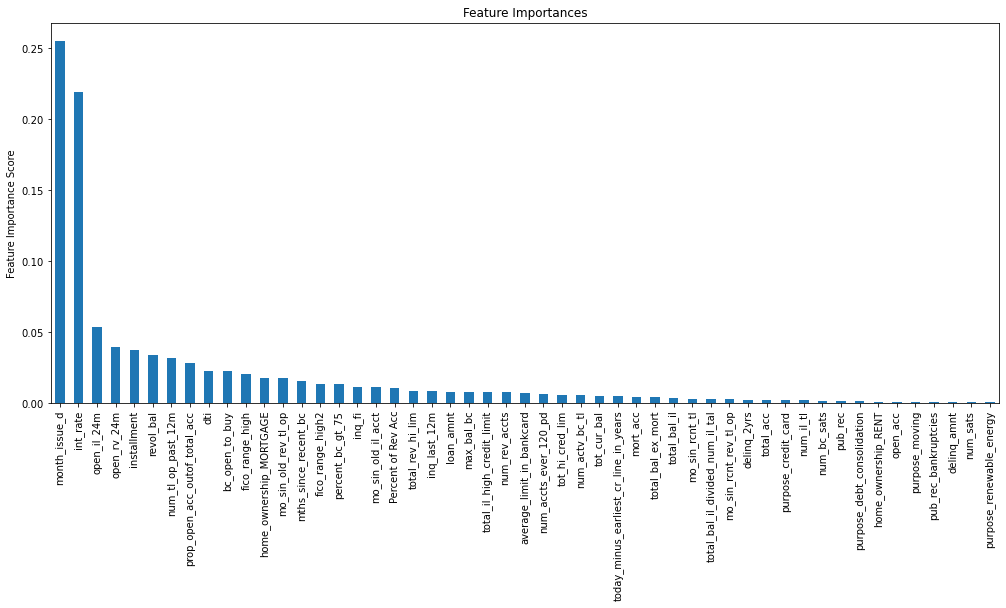

In [56]:
feature_importances = XG_Boost.feature_importances_
predictors = x_train_for_models.columns
#Print Feature Importance:
plt.figure(figsize=(17,7))
feat_imp = pd.Series(feature_importances, predictors).sort_values(ascending=False)

threshold_importance = 0.0005
feat_imp_new = feat_imp[feat_imp>=threshold_importance]

feat_imp_new.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [55]:
feat_imp.head(20)

month_issue_d                   0.2551
int_rate                        0.2193
open_il_24m                     0.0534
open_rv_24m                     0.0395
installment                     0.0376
revol_bal                       0.0340
num_tl_op_past_12m              0.0316
prop_open_acc_outof_total_acc   0.0281
dti                             0.0224
bc_open_to_buy                  0.0223
fico_range_high                 0.0204
home_ownership_MORTGAGE         0.0179
mo_sin_old_rev_tl_op            0.0175
mths_since_recent_bc            0.0155
fico_range_high2                0.0137
percent_bc_gt_75                0.0135
inq_fi                          0.0111
mo_sin_old_il_acct              0.0110
Percent of Rev Acc              0.0105
total_rev_hi_lim                0.0088
dtype: float64

### Comparing to base line of "grades":
If we invested only according to grades - with the case of **all the loans** compared to a case of investing according to the grades of **the Suggested portfolio** - what would have been the weighted average realized return:

In [57]:
print("Base line Grades - all the loans")
display(baseline_grades_original)
print("------------------------------------------------------------------------")
print("Base line Grades - Suggested portfolio with threshold of: ", threshold)
print("XGBOOST")
display(baseline_grades_XGB)

Base line Grades - all the loans


,weighted_average,weighted SD,Number of Loans
A,1.8616,4.5150,56753
B,1.5329,7.1495,92005
C,0.7989,9.4387,74610
D,-0.1942,11.5450,30543
E,-1.0223,13.3408,8798
F,-2.1095,14.5592,2114
G,-3.6289,15.2552,493
Total All loans Together,1.0764,8.4148,265316


------------------------------------------------------------------------
Base line Grades - Suggested portfolio with threshold of:  0.75
XGBOOST


,weighted_average,weighted SD,Number of Loans
A,2.1611,4.3687,9006
B,2.3072,6.4866,13615
C,2.6130,8.1188,5728
D,3.5900,9.4213,548
E,6.1465,9.0121,70
F,3.2977,10.7355,3
Total All Suggested Portfolio,2.3438,6.3050,28970


# Profit Curve

### Function: <font color = blue > profit_curve: </font>

This function gets **6 arguments**:

1. **model** - A model **After fitting** to x_train_for_models (the original x_train without the columns: "id", "funded_amnt_inv", "realized_return", "grade", "sub_grade" (those columns are needed for calculating the actual realized return gained by the suggested portfolio)


2. **x_test** -  the original x_test (with all the columns)


3. **x_test_for_models** -  the original x_test without the columns: "id", "funded_amnt_inv", "realized_return", "grade", "sub_grade" (those columns are needed for calculating the actual realized return gained by the suggested portfolio)


4. **y_test** - y_test array


5. **display_df_profit_curve** - a boolean. default = False. If you wish to see a dataframe with the different thresolhds, the weighted average realize return (of the Suggested Portfolio that was chosen as a result of the threshold), the number of loans that were left in the suggested portfolio (as a rasult of the threshold), The total investment in dollars (If the company would have invested in all the loans in the suggested portfolio for a given thresholid it woild have invested the amount of money in this column) and the amount of FN and TN.

6. **model_name** - a string specifying the name of the model (only for convenient). If not given, the model will use the model argument for the name.


### This function **returns 2 values + Profit Curve:**
1. **df_profit_curve** = The "threshold table" - a dataframe with the different thresolhds, the weighted average realize return (of the Suggested Portfolio that was chosen as a result of the threshold), the number of loans that were left in the suggested portfolio (as a rasult of the threshold), the total money ( in thousands of dollars) the company would need to invest, and the number of the FN and TN cases for each threshold.
   
2. **suggested_port_list**: a list containing all the suggested portfolios that we got as a result of each and every threshold.

    
**Note:** The function **outputs a profit curve**, **<font color = forestgreen > the green dot </font>** represents the **best** threshold (the one that gained the highest realized return). The function will print that threshold, the number of loans that participated in the calculation of the realized return and it will also print that highest reazlied return.

In [46]:
def profit_curve (model, x_test, x_test_for_models, y_test, display_df_profit_curve = False, model_name = None):
    #suppress scientific notation in Pandas
    pd.set_option('display.float_format', lambda x: '%.4f' % x)

    if model_name == None:
        model_name = model
    
    profit_curve = "Profit Curve Of Model: "
    title = profit_curve+model_name
    
    y_pred = model.predict(x_test_for_models)
    y_pred_prob = model.predict_proba(x_test_for_models)
    
    x_test_final = x_test.copy()
    x_test_final["realized_return_higher_2%_prediction"] = y_pred
    x_test_final["probability_higher_2%"] = y_pred_prob[0:, 0] 
    x_test_final["y_test"] = y_test
    x_test_final["Confusion Matrix"] =  np.where((x_test_final["realized_return_higher_2%_prediction"] == 0) &(x_test_final["y_test"] == 0), "TN", np.where((x_test_final["realized_return_higher_2%_prediction"] == 1) &(x_test_final["y_test"] == 1), "TP", np.where((x_test_final["realized_return_higher_2%_prediction"] == 0) &(x_test_final["y_test"] == 1), "FN", "FP")))
    CM = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = CM.ravel()
    
    #suggested portfolio

    #filtering all the loans that the predictor classified as "1" (=realized return smaller than 2%)
    #and filter loans that their probability to be "0" (=realized return higher than 2%) smaller than the given threshold.
    weighted_average_realized_returns_SP_list =[]
    suggested_port_list = []
    number_of_loans = []
    FN_list =[]
    TN_list = []
    total_investments =[]
    thresholds = np.arange(0.5, 1, 0.02)
    i = 0
    final_threshold_to_show =[]
    for threshold in thresholds:
        suggested_port = x_test_final[(x_test_final["realized_return_higher_2%_prediction"]==0) & (x_test_final["probability_higher_2%"]>=threshold)]

        #The weighted average of the realized return of the suggested portfolio (SP):
        if suggested_port.shape[0] > 0:
            suggested_port_list.append(suggested_port)
            number_of_loans.append(suggested_port.shape[0])
            weighted_average_realized_returns_SP_list.append(np.average(suggested_port["realized_return"], weights=suggested_port["funded_amnt_inv"]))
            FN_list.append(np.sum(suggested_port["Confusion Matrix"] == "FN"))
            TN_list.append(np.sum(suggested_port["Confusion Matrix"] == "TN"))
            total_investments.append(np.sum(suggested_port["funded_amnt_inv"])/1000)
            final_threshold_to_show.append(threshold)

        #print(weighted_average_realized_returns_SP_list[i])
        i = i + 1
    
    #Creating Data frame of thresholds, weighted average of realized return and number of loans for each threhold
    
    weighted_average_realized_returns_SP_list = np.asarray(weighted_average_realized_returns_SP_list).reshape(-1,1)
    thresholds = np.asarray(final_threshold_to_show).reshape(-1,1)
    number_of_loans =  np.asarray(number_of_loans).reshape(-1,1)
    FN_list = np.asarray(FN_list).reshape(-1,1).astype(int)
    TN_list = np.asarray(TN_list).reshape(-1,1).astype(int)
    total_investments = np.round(np.asarray(total_investments),3).reshape(-1,1)
    
    combining_all = np.hstack((thresholds, weighted_average_realized_returns_SP_list, number_of_loans, total_investments, FN_list, TN_list))
    df_profit_curve = pd.DataFrame(data = combining_all,
                              columns = ["thresholds", "WA_Realized_return_SP", "number of loans", "Total investment in thousands of $", "Number of FN", "Number of TN"])
    
    if display_df_profit_curve == True:
        display(df_profit_curve)
    
    #plotting
    index_max_realized_return = df_profit_curve.idxmax(axis = 0)["WA_Realized_return_SP"] #The index of the highest realzied return
    best_threshold = df_profit_curve.iloc[[index_max_realized_return],[0,1,2]]
    
    sns.scatterplot(x = "thresholds", y = "WA_Realized_return_SP", data = df_profit_curve)
    sns.lineplot(x = "thresholds", y = "WA_Realized_return_SP", data = df_profit_curve)
    #plt.axvline(x_value_max, c = "black")
    plot = sns.scatterplot(x = "thresholds", y = "WA_Realized_return_SP", data = best_threshold, color = "green").set_title(title)
    
    #ax.set(xlabel='Threshold', ylabel='Realized return')

    
    print("The best Threshold is %3.3f, this leads to suggested portfolio of %3.0f loans and weighted average realized return of %3.4f" %(best_threshold.iloc[0,0], best_threshold.iloc[0,2], best_threshold.iloc[0,1]))
    
    return df_profit_curve, suggested_port_list


## <font color = royalblue > Profit Curve </font>  for the XG Boost Model

The best Threshold is 0.920, this leads to suggested portfolio of   1 loans and weighted average realized return of 4.8641


,thresholds,WA_Realized_return_SP,number of loans,Total investment in thousands of $,Number of FN,Number of TN
0,0.5000,1.1894,69615.0000,910831.3570,19261.0000,50354.0000
1,0.5200,1.2195,68971.0000,901522.3070,18941.0000,50030.0000
2,0.5400,1.2448,68185.0000,890849.4820,18583.0000,49602.0000
3,0.5600,1.3007,67115.0000,876351.4820,18065.0000,49050.0000
4,0.5800,1.3513,65700.0000,857311.7570,17454.0000,48246.0000
5,0.6000,1.4405,63637.0000,830272.0250,16598.0000,47039.0000
6,0.6200,1.5194,60890.0000,795966.0000,15524.0000,45366.0000
7,0.6400,1.6236,57495.0000,754610.9750,14227.0000,43268.0000
8,0.6600,1.7364,53248.0000,702290.8000,12740.0000,40508.0000
9,0.6800,1.8846,48309.0000,641297.0250,11071.0000,37238.0000


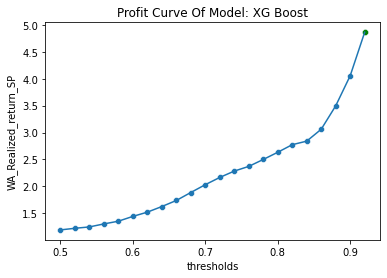

In [47]:
#For the XGBoost Model
df_profit_curve, suggested_port_list = profit_curve(XG_Boost, x_test, x_test_for_models, y_test, model_name = "XG Boost")
df_profit_curve

# Roc Curve

### Function: <font color = blue > roc_curves_RAR </font>
This function gets 3 arguments:
1. **models** - a list of models **after fitted to the x_train and y_train**
2. **x_test** - a **x_test_for_models** array
3. **y_test** - a y_test array (The true labels)

This function **returns ROC Curves of all the models inserted in the models argument** and returns the **AUC** values

In [48]:
def roc_curves_RAR(models, x_test_for_models, y_test):
    x_test = x_test_for_models
    plt.figure(figsize=(8,8))
    AUC_scores = []
    
    for model in models:
        y_test_probs = model.predict_proba(x_test)
        FPR, TPR, thresholds = roc_curve(y_test, y_test_probs[:, 1])
        plt.plot(FPR, TPR, linewidth=2, label=model)
        plt.plot([0,1], [0,1], 'k--')
        plt.axis([0, 1, 0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        AUC_scores.append(roc_auc_score(y_test, y_test_probs[:, 1]))

    #AUC:
    models_char=[]
    for model in models:
        models_char.append(str(model))

    AUC_scores = np.asarray(AUC_scores).reshape(-1,1)
    AUC_table = pd.DataFrame(data = AUC_scores,
                        index = models_char,
                        columns = ["AUC Value"]) 
    display(AUC_table.round(4))                                                                 

,AUC Value
"GradientBoostingClassifier(n_estimators=200, random_state=1, verbose=1)",0.6354


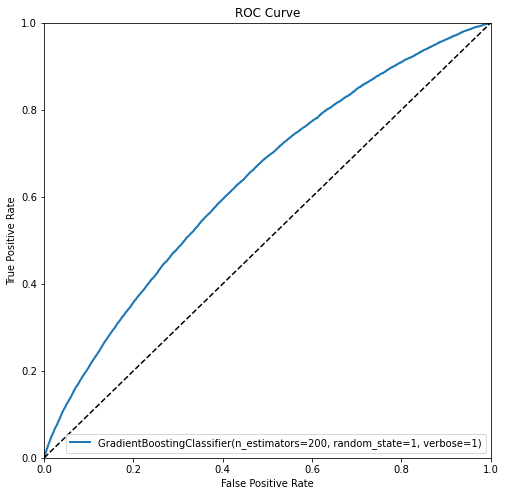

In [49]:
models =  [XG_Boost]
roc_curves_RAR(models = models, x_test_for_models=x_test_for_models, y_test=y_test)

# Precision VS Recall Curve

### Function: <font color = blue > Precision_VS_Recall_RAR </font>
This function gets 3 arguments:
1. **models** - a list of models **after fitted to the x_train and y_train**
2. **x_test** - a **x_test_for_models** array
3. **y_test** - a y_test array (The true labels)

This function **returns Precision VS Recall Curves of all the models inserted in the models argument**

In [51]:
def Precision_VS_Recall_RAR(models, x_test_for_models, y_test):
    
    x_test = x_test_for_models
    plt.figure(figsize=(8,8))
    
    for model in models:
        y_test_probs = model.predict_proba(x_test)
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_probs[:, 1])
        plt.plot(precisions, recalls, label=model)
        plt.axis([0, 1, 0, 1])
        plt.xlabel('recalls')
        plt.ylabel('precisions')
        plt.title('PrescionXRecall Curve: precisions/recalls tradeoff')
        plt.legend()


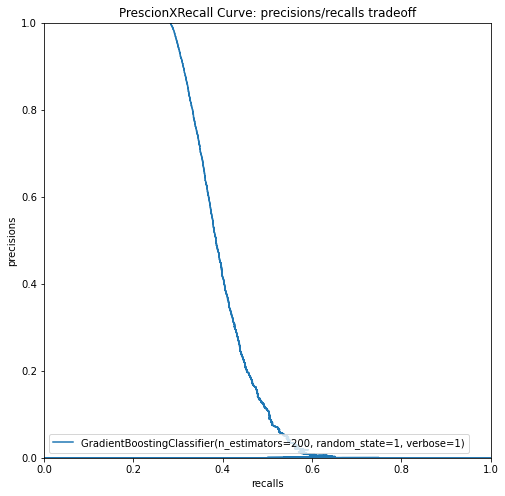

In [52]:
models =  [XG_Boost]
Precision_VS_Recall_RAR(models, x_test_for_models, y_test)

### Function: <font color = blue > analyze_SP: </font>

This function gets **2 arguments**:

1. **Suggested_portfolio** - A Suggested portfolio table = the **First** output of the function **<font color = blue >  model_all </font>** 


2. **columns_list_to_show** - list of column names in suggested portfolio that wewant to see



### This function **returns:**

This function enables seeing specific columns of the Suggested Portfolio


In [58]:
def analyze_SP(Suggested_portfolio, columns_list_to_show):
    Suggested_portfolio["TN/FN"] =  np.where((suggested_port_XGB["realized_return_higher_2%_prediction"] == 0) &(suggested_port_XGB["true_label"] == 0), "TN", "FN")
    list_cols_problems = []
    final_cols_show =[]
    for column in columns_list_to_show:
        if column not in Suggested_portfolio.columns:
            list_cols_problems.append(column)
        else:
            final_cols_show.append(column)
            
    if len(list_cols_problems) > 0:       
        print("Columns that you asked to show, however they don't exist in the given Suggested Portfolio table: ")
        for col in list_cols_problems:
            print(col)
        print()
        
    Suggested_portfolio_show = Suggested_portfolio[final_cols_show]
    
    return Suggested_portfolio_show

In [59]:
columns_list_to_show = ["grade", "sub_grade", "realized_return", "funded_amnt_inv", "true_label",
                        "realized_return_higher_2%_prediction", "probability_higher_2%", "TN/FN"]

table1 = analyze_SP(suggested_port_XGB, columns_list_to_show)
display(table1)
print()

print("All the FN cases:")
table1[table1["TN/FN"] == "FN"]

,grade,sub_grade,realized_return,funded_amnt_inv,true_label,realized_return_higher_2%_prediction,probability_higher_2%,TN/FN
102627,A,A1,2.7945,24000.0000,0,0,0.7674,TN
143755,C,C2,3.6531,5875.0000,0,0,0.8239,TN
25075,A,A4,3.1826,23000.0000,0,0,0.8079,TN
108726,B,B3,2.8736,14000.0000,0,0,0.7653,TN
102257,C,C4,5.2510,7500.0000,0,0,0.8195,TN
...,...,...,...,...,...,...,...,...
65055,B,B1,3.5606,3600.0000,0,0,0.7590,TN
113932,B,B5,5.0836,7500.0000,0,0,0.7606,TN
131717,B,B5,6.1509,21000.0000,0,0,0.8464,TN
84860,C,C2,7.1176,30000.0000,0,0,0.8235,TN



All the FN cases:


,grade,sub_grade,realized_return,funded_amnt_inv,true_label,realized_return_higher_2%_prediction,probability_higher_2%,TN/FN
157963,B,B4,1.9937,30500.0000,1,0,0.7839,FN
94593,B,B3,-4.9412,9600.0000,1,0,0.7920,FN
64241,A,A1,1.4015,35000.0000,1,0,0.8107,FN
123474,B,B3,1.7436,11200.0000,1,0,0.8101,FN
130130,C,C1,-10.9103,8000.0000,1,0,0.7945,FN
...,...,...,...,...,...,...,...,...
133707,A,A5,1.6160,14000.0000,1,0,0.8300,FN
42407,B,B5,-5.8526,21000.0000,1,0,0.7964,FN
40370,D,D2,0.0673,1000.0000,1,0,0.7511,FN
112482,C,C1,-6.0138,10000.0000,1,0,0.8169,FN


# Parameter Optimization + Feature Selection - XGBoost

# Feature Selection

In [153]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


In [145]:
XG_Boost = GradientBoostingClassifier(n_estimators=100)

In [ ]:
num_Predictors = x_train_for_models.shape[1] - 2

Bacward_selection = SFS(XG_Boost, 
           k_features=num_Predictors, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=3)
Bacward_selection.fit(x_train_for_models,y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1938           0.0044            5.13m
         2           1.1889           0.0037            4.82m
         3           1.1880           0.0031            5.11m
         4           1.1856           0.0024            5.29m
         5           1.1812           0.0022            5.19m
         6           1.1803           0.0024            5.07m
         7           1.1775           0.0019            4.95m
         8           1.1757           0.0014            4.83m
         9           1.1754           0.0014            4.74m
        10           1.1711           0.0014            4.69m
        20           1.1637           0.0005            4.21m
        30           1.1575           0.0002            3.94m
        40           1.1592           0.0001            3.66m
        50           1.1526           0.0000            3.42m
        60           1.1526          -0.0001            3.18m
       

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1966           0.0039            3.98m
         2           1.1913           0.0033            3.91m
         3           1.1890           0.0026            3.88m
         4           1.1823           0.0031            3.86m
         5           1.1838           0.0019            3.84m
         6           1.1790           0.0026            3.82m
         7           1.1771           0.0020            3.85m
         8           1.1764           0.0014            3.82m
         9           1.1777           0.0015            3.79m
        10           1.1738           0.0010            3.77m
        20           1.1632           0.0005            3.81m
        30           1.1611           0.0002            3.51m
        40           1.1563           0.0002            3.26m
        50           1.1560           0.0001            3.03m
        60           1.1524           0.0001            2.81m
       

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.2min remaining:    0.0s


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1930           0.0042            3.86m
         2           1.1921           0.0034            3.87m
         3           1.1895           0.0029            3.87m
         4           1.1835           0.0025            3.86m
         5           1.1818           0.0027            3.87m
         6           1.1818           0.0022            4.05m
         7           1.1764           0.0016            4.01m
         8           1.1765           0.0017            3.96m
         9           1.1733           0.0013            3.91m
        10           1.1725           0.0009            3.90m
        20           1.1649           0.0005            3.76m
        30           1.1571           0.0002            3.49m
        40           1.1566           0.0001            3.25m
        50           1.1543           0.0001            3.02m
        60           1.1517           0.0000            2.81m
       

         7           1.1766           0.0018            3.98m
         8           1.1759           0.0014            3.96m
         9           1.1732           0.0015            3.92m
        10           1.1733           0.0013            3.90m
        20           1.1632           0.0004            3.72m
        30           1.1591           0.0002            3.46m
        40           1.1575           0.0001            3.24m
        50           1.1532           0.0001            3.02m
        60           1.1499          -0.0001            2.81m
        70           1.1515           0.0000            2.61m
        80           1.1495          -0.0000            2.42m
        90           1.1480          -0.0000            2.21m
       100           1.1468           0.0000            2.01m
       200           1.1380          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1922           0.0046            3.99m
       

        50           1.1516           0.0000            3.74m
        60           1.1494           0.0001            3.39m
        70           1.1503          -0.0000            3.07m
        80           1.1482           0.0000            2.79m
        90           1.1474          -0.0000            2.52m
       100           1.1450          -0.0000            2.26m
       200           1.1367          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1950           0.0044            4.29m
         2           1.1901           0.0039            4.16m
         3           1.1864           0.0032            4.05m
         4           1.1842           0.0026            4.01m
         5           1.1798           0.0021            3.96m
         6           1.1789           0.0019            3.93m
         7           1.1770           0.0020            3.90m
         8           1.1759           0.0018            3.94m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1957           0.0046            4.14m
         2           1.1909           0.0035            4.04m
         3           1.1895           0.0030            4.34m
         4           1.1824           0.0029            4.22m
         5           1.1792           0.0020            4.22m
         6           1.1815           0.0020            4.24m
         7           1.1753           0.0018            4.22m
         8           1.1729           0.0018            4.17m
         9           1.1733           0.0012            4.12m
        10           1.1738           0.0014            4.07m
        20           1.1642           0.0004            3.78m
        30           1.1571           0.0004            3.52m
        40           1.1548           0.0002            3.29m
        50           1.1511           0.0001            3.18m
        60           1.1500           0.0000            2.95m
       

         7           1.1767           0.0019            3.86m
         8           1.1747           0.0015            3.82m
         9           1.1732           0.0015            3.79m
        10           1.1729           0.0012            3.77m
        20           1.1628           0.0006            3.57m
        30           1.1555           0.0002            3.37m
        40           1.1539           0.0001            3.16m
        50           1.1521          -0.0000            3.01m
        60           1.1496           0.0000            2.80m
        70           1.1481           0.0001            2.61m
        80           1.1488          -0.0001            2.41m
        90           1.1451          -0.0000            2.20m
       100           1.1435           0.0000            2.00m
       200           1.1371          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1951           0.0045            3.99m
       

        50           1.1532           0.0001            3.04m
        60           1.1527           0.0000            2.83m
        70           1.1515          -0.0000            2.62m
        80           1.1483          -0.0001            2.42m
        90           1.1458          -0.0000            2.21m
       100           1.1444           0.0000            2.02m
       200           1.1346          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1934           0.0047            3.93m
         2           1.1882           0.0038            3.91m
         3           1.1855           0.0031            3.95m
         4           1.1860           0.0026            4.31m
         5           1.1836           0.0022            4.33m
         6           1.1810           0.0018            4.33m
         7           1.1759           0.0019            4.38m
         8           1.1751           0.0019            4.34m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1946           0.0046            3.97m
         2           1.1909           0.0039            3.92m
         3           1.1852           0.0032            3.89m
         4           1.1850           0.0027            3.88m
         5           1.1815           0.0023            3.97m
         6           1.1799           0.0019            4.02m
         7           1.1794           0.0017            4.03m
         8           1.1771           0.0019            4.00m
         9           1.1707           0.0016            3.96m
        10           1.1713           0.0010            3.92m
        20           1.1626           0.0005            3.64m
        30           1.1594           0.0001            3.41m
        40           1.1522           0.0001            3.23m
        50           1.1532           0.0000            3.02m
        60           1.1503           0.0001            2.82m
       

         7           1.1781           0.0022            4.17m
         8           1.1733           0.0015            4.13m
         9           1.1750           0.0013            4.07m
        10           1.1725           0.0014            4.02m
        20           1.1628           0.0005            3.69m
        30           1.1571           0.0002            3.46m
        40           1.1541           0.0001            3.23m
        50           1.1519           0.0001            3.02m
        60           1.1500           0.0000            2.83m
        70           1.1474           0.0001            2.62m
        80           1.1459           0.0000            2.41m
        90           1.1477          -0.0000            2.22m
       100           1.1431           0.0000            2.02m
       200           1.1342          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1941           0.0046            4.14m
       

        50           1.1549           0.0001            3.01m
        60           1.1503          -0.0000            2.82m
        70           1.1484          -0.0000            2.61m
        80           1.1474           0.0000            2.42m
        90           1.1455          -0.0000            2.21m
       100           1.1423           0.0000            2.01m
       200           1.1348          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1941           0.0044            3.96m
         2           1.1882           0.0034            3.91m
         3           1.1879           0.0031            3.90m
         4           1.1846           0.0027            3.87m
         5           1.1817           0.0021            3.86m
         6           1.1778           0.0024            3.84m
         7           1.1756           0.0016            3.82m
         8           1.1760           0.0015            3.80m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1935           0.0045            3.89m
         2           1.1894           0.0036            3.86m
         3           1.1867           0.0032            3.85m
         4           1.1850           0.0025            3.83m
         5           1.1818           0.0022            3.83m
         6           1.1773           0.0017            3.80m
         7           1.1764           0.0016            3.77m
         8           1.1790           0.0017            3.75m
         9           1.1767           0.0014            3.73m
        10           1.1736           0.0014            3.71m
        20           1.1639           0.0005            3.65m
        30           1.1595           0.0003            3.41m
        40           1.1570           0.0001            3.21m
        50           1.1529           0.0001            3.00m
        60           1.1493           0.0000            2.79m
       

         7           1.1764           0.0016            3.77m
         8           1.1749           0.0020            3.74m
         9           1.1739           0.0016            3.77m
        10           1.1709           0.0012            3.76m
        20           1.1655           0.0005            5.23m
        30           1.1586           0.0003            6.50m
        40           1.1568           0.0000            6.65m
        50           1.1539           0.0001            7.32m
        60           1.1485          -0.0000            6.32m
        70           1.1500           0.0001            5.42m
        80           1.1492          -0.0000            4.71m
        90           1.1461          -0.0000            4.11m
       100           1.1454           0.0001            3.66m
       200           1.1363          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1937           0.0047            3.81m
       

        50           1.1544           0.0000            2.95m
        60           1.1507           0.0000            2.78m
        70           1.1530           0.0000            2.57m
        80           1.1474           0.0000            2.39m
        90           1.1444          -0.0000            2.18m
       100           1.1473          -0.0000            1.97m
       200           1.1382          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1956           0.0047            6.90m
         2           1.1889           0.0037            5.30m
         3           1.1848           0.0032            4.76m
         4           1.1806           0.0027            4.56m
         5           1.1817           0.0022            4.41m
         6           1.1794           0.0022            4.27m
         7           1.1754           0.0017            4.16m
         8           1.1767           0.0013            4.08m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1901           0.0047            4.31m
         2           1.1898           0.0038            4.19m
         3           1.1860           0.0030            4.15m
         4           1.1825           0.0027            4.03m
         5           1.1796           0.0023            3.95m
         6           1.1805           0.0017            3.90m
         7           1.1797           0.0020            3.85m
         8           1.1728           0.0017            3.81m
         9           1.1744           0.0016            3.78m
        10           1.1707           0.0011            3.75m
        20           1.1618           0.0004            3.51m
        30           1.1572           0.0002            3.29m
        40           1.1561           0.0001            3.14m
        50           1.1544           0.0001            2.95m
        60           1.1502           0.0001            2.78m
       

         7           1.1764           0.0019            3.87m
         8           1.1742           0.0015            3.84m
         9           1.1754           0.0016            3.83m
        10           1.1742           0.0013            3.81m
        20           1.1636           0.0006            3.61m
        30           1.1568           0.0001            3.45m
        40           1.1531           0.0002            3.22m
        50           1.1523           0.0001            3.00m
        60           1.1498           0.0000            2.81m
        70           1.1488           0.0001            2.60m
        80           1.1487          -0.0000            2.41m
        90           1.1470           0.0000            2.20m
       100           1.1438          -0.0000            2.00m
       200           1.1341          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1923           0.0045            4.11m
       

        50           1.1527           0.0002            2.97m
        60           1.1500           0.0001            2.79m
        70           1.1493          -0.0000            2.58m
        80           1.1456          -0.0000            2.38m
        90           1.1461           0.0000            2.18m
       100           1.1475           0.0000            2.00m
       200           1.1372          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1925           0.0045            3.94m
         2           1.1866           0.0040            3.90m
         3           1.1860           0.0032            3.87m
         4           1.1822           0.0025            3.84m
         5           1.1803           0.0023            3.81m
         6           1.1788           0.0018            3.80m
         7           1.1766           0.0017            3.80m
         8           1.1756           0.0015            3.77m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1929           0.0047            4.41m
         2           1.1880           0.0040            4.43m
         3           1.1845           0.0031            4.36m
         4           1.1824           0.0026            4.36m
         5           1.1815           0.0025            4.33m
         6           1.1798           0.0017            4.33m
         7           1.1775           0.0017            4.30m
         8           1.1746           0.0019            4.27m
         9           1.1744           0.0014            4.28m
        10           1.1739           0.0015            4.27m
        20           1.1619           0.0004            4.00m
        30           1.1580           0.0003            3.81m
        40           1.1540           0.0001            3.59m
        50           1.1515           0.0001            3.36m
        60           1.1504           0.0000            3.12m
       

         7           1.1756           0.0015            4.17m
         8           1.1734           0.0017            4.13m
         9           1.1732           0.0015            4.19m
        10           1.1719           0.0013            4.17m
        20           1.1640           0.0007            3.97m
        30           1.1603           0.0002            3.74m
        40           1.1551           0.0002            3.51m
        50           1.1533           0.0001            3.27m
        60           1.1510          -0.0000            3.07m
        70           1.1508           0.0000            2.85m
        80           1.1462          -0.0000            2.62m
        90           1.1466           0.0000            2.40m
       100           1.1431          -0.0001            2.19m
       200           1.1354          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1948           0.0046            4.37m
       

        50           1.1519           0.0000            3.31m
        60           1.1474           0.0001            3.09m
        70           1.1491          -0.0000            2.86m
        80           1.1483          -0.0000            2.63m
        90           1.1475          -0.0000            2.42m
       100           1.1456          -0.0000            2.20m
       200           1.1350          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1933           0.0045            4.38m
         2           1.1891           0.0036            4.28m
         3           1.1855           0.0031            4.49m
         4           1.1845           0.0025            4.48m
         5           1.1798           0.0022            4.39m
         6           1.1812           0.0023            4.39m
         7           1.1751           0.0016            4.37m
         8           1.1752           0.0017            4.32m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1940           0.0044            5.55m
         2           1.1890           0.0033            4.95m
         3           1.1883           0.0032            4.69m
         4           1.1848           0.0025            4.57m
         5           1.1810           0.0026            4.53m
         6           1.1788           0.0022            4.48m
         7           1.1776           0.0014            4.44m
         8           1.1753           0.0017            4.43m
         9           1.1765           0.0013            4.38m
        10           1.1724           0.0012            4.32m
        20           1.1632           0.0005            4.03m
        30           1.1611           0.0002            3.78m
        40           1.1529           0.0001            3.54m
        50           1.1546          -0.0000            3.32m
        60           1.1515           0.0001            3.11m
       

         7           1.1766           0.0019            4.20m
         8           1.1754           0.0014            4.17m
         9           1.1734           0.0015            4.14m
        10           1.1722           0.0011            4.09m
        20           1.1642           0.0005            3.90m
        30           1.1572           0.0002            3.70m
        40           1.1564           0.0001            3.47m
        50           1.1528           0.0002            3.26m
        60           1.1515           0.0000            3.03m
        70           1.1495          -0.0000            2.82m
        80           1.1470          -0.0000            2.61m
        90           1.1433          -0.0000            2.39m
       100           1.1463           0.0000            2.18m
       200           1.1331          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1920           0.0046            5.02m
       

        50           1.1532           0.0001            2.92m
        60           1.1525           0.0001            2.72m
        70           1.1522          -0.0000            2.55m
        80           1.1463          -0.0001            2.35m
        90           1.1484           0.0000            2.15m
       100           1.1472           0.0000            1.95m
       200           1.1341          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1923           0.0049            4.28m
         2           1.1907           0.0036            4.06m
         3           1.1879           0.0031            4.04m
         4           1.1858           0.0026            3.96m
         5           1.1810           0.0021            3.90m
         6           1.1789           0.0022            3.85m
         7           1.1777           0.0016            3.83m
         8           1.1755           0.0020            3.80m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1938           0.0048            3.86m
         2           1.1885           0.0037            4.08m
         3           1.1854           0.0030            3.97m
         4           1.1844           0.0027            4.18m
         5           1.1801           0.0023            4.12m
         6           1.1792           0.0020            4.05m
         7           1.1785           0.0016            3.98m
         8           1.1780           0.0015            3.92m
         9           1.1755           0.0017            3.90m
        10           1.1724           0.0014            3.88m
        20           1.1610           0.0005            3.56m
        30           1.1597           0.0003            3.34m
        40           1.1546           0.0001            3.16m
        50           1.1538           0.0002            2.95m
        60           1.1543           0.0000            2.74m
       

         7           1.1768           0.0017            3.94m
         8           1.1787           0.0017            3.90m
         9           1.1729           0.0015            3.86m
        10           1.1726           0.0011            3.82m
        20           1.1629           0.0006            3.59m
        30           1.1565           0.0003            3.36m
        40           1.1520           0.0001            3.15m
        50           1.1511           0.0001            2.95m
        60           1.1483           0.0001            2.76m
        70           1.1509          -0.0000            2.57m
        80           1.1469           0.0001            2.38m
        90           1.1440           0.0000            2.17m
       100           1.1478          -0.0000            1.97m
       200           1.1356          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1916           0.0045            3.99m
       

        50           1.1531           0.0000            2.89m
        60           1.1520           0.0000            2.68m
        70           1.1466           0.0000            2.48m
        80           1.1451          -0.0001            2.30m
        90           1.1465          -0.0000            2.11m
       100           1.1461          -0.0001            1.91m
       200           1.1351          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1933           0.0045            3.79m
         2           1.1889           0.0036            3.74m
         3           1.1848           0.0030            3.72m
         4           1.1804           0.0024            3.70m
         5           1.1807           0.0025            3.68m
         6           1.1810           0.0019            3.66m
         7           1.1776           0.0015            3.64m
         8           1.1758           0.0019            3.62m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1893           0.0047            3.85m
         2           1.1912           0.0039            3.84m
         3           1.1841           0.0032            3.81m
         4           1.1854           0.0028            3.80m
         5           1.1844           0.0025            3.78m
         6           1.1801           0.0019            3.76m
         7           1.1781           0.0021            3.74m
         8           1.1753           0.0014            3.74m
         9           1.1741           0.0016            3.74m
        10           1.1718           0.0012            3.81m
        20           1.1611           0.0003            3.77m
        30           1.1581           0.0002            3.47m
        40           1.1544           0.0001            3.23m
        50           1.1530          -0.0001            3.01m
        60           1.1521           0.0000            2.79m
       

         7           1.1744           0.0019            4.08m
         8           1.1754           0.0016            4.01m
         9           1.1720           0.0013            4.06m
        10           1.1737           0.0013            4.12m
        20           1.1615           0.0005            3.76m
        30           1.1585           0.0002            3.45m
        40           1.1556           0.0001            3.20m
        50           1.1555           0.0000            2.98m
        60           1.1481          -0.0000            2.80m
        70           1.1467           0.0001            2.58m
        80           1.1469           0.0000            2.39m
        90           1.1432           0.0000            2.18m
       100           1.1461          -0.0000            1.98m
       200           1.1342          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1924           0.0046            3.95m
       

        50           1.1533           0.0001            2.89m
        60           1.1501          -0.0000            2.68m
        70           1.1498           0.0000            2.51m
        80           1.1497          -0.0000            2.32m
        90           1.1483          -0.0001            2.12m
       100           1.1436          -0.0000            1.93m
       200           1.1358          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1904           0.0045            3.89m
         2           1.1876           0.0038            3.90m
         3           1.1882           0.0029            4.06m
         4           1.1869           0.0025            4.11m
         5           1.1813           0.0026            4.23m
         6           1.1793           0.0019            4.24m
         7           1.1764           0.0016            4.17m
         8           1.1753           0.0017            4.12m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1961           0.0043            5.51m
         2           1.1879           0.0036            4.92m
         3           1.1893           0.0030            4.75m
         4           1.1860           0.0027            4.50m
         5           1.1833           0.0021            4.38m
         6           1.1773           0.0019            4.65m
         7           1.1791           0.0019            4.48m
         8           1.1744           0.0017            4.36m
         9           1.1722           0.0014            4.25m
        10           1.1729           0.0012            4.17m
        20           1.1653           0.0006            3.81m
        30           1.1589           0.0002            3.46m
        40           1.1553           0.0001            3.31m
        50           1.1550           0.0000            3.04m
        60           1.1526           0.0000            2.82m
       

         7           1.1786           0.0018            3.83m
         8           1.1746           0.0016            3.81m
         9           1.1745           0.0012            3.78m
        10           1.1716           0.0012            3.76m
        20           1.1656           0.0004            3.58m
        30           1.1586           0.0003            3.42m
        40           1.1559           0.0002            3.21m
        50           1.1533           0.0001            3.00m
        60           1.1522           0.0001            2.79m
        70           1.1491          -0.0000            2.58m
        80           1.1497           0.0000            2.39m
        90           1.1447          -0.0001            2.19m
       100           1.1469          -0.0000            1.99m
       200           1.1343           0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1918           0.0048            3.92m
       

        50           1.1545          -0.0000            2.91m
        60           1.1528           0.0001            2.71m
        70           1.1507           0.0000            2.51m
        80           1.1463          -0.0001            2.31m
        90           1.1487           0.0000            2.12m
       100           1.1441          -0.0000            1.93m
       200           1.1331          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1914           0.0048            4.17m
         2           1.1881           0.0038            3.98m
         3           1.1851           0.0031            3.90m
         4           1.1818           0.0023            3.84m
         5           1.1818           0.0022            3.80m
         6           1.1805           0.0017            3.81m
         7           1.1764           0.0019            3.77m
         8           1.1738           0.0017            3.75m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1938           0.0046            3.87m
         2           1.1905           0.0037            3.88m
         3           1.1880           0.0028            3.86m
         4           1.1828           0.0026            3.84m
         5           1.1831           0.0024            3.83m
         6           1.1786           0.0019            3.82m
         7           1.1763           0.0021            3.85m
         8           1.1761           0.0017            3.97m
         9           1.1731           0.0012            4.04m
        10           1.1732           0.0014            4.04m
        20           1.1626           0.0005            4.00m
        30           1.1580           0.0003            3.69m
        40           1.1551           0.0001            3.37m
        50           1.1534           0.0002            3.16m
        60           1.1505           0.0000            2.91m
       

         7           1.1778           0.0023            3.83m
         8           1.1751           0.0014            3.81m
         9           1.1744           0.0016            3.80m
        10           1.1689           0.0015            3.78m
        20           1.1627           0.0006            3.66m
        30           1.1579           0.0003            3.43m
        40           1.1560           0.0001            3.22m
        50           1.1523           0.0001            3.01m
        60           1.1489           0.0000            2.80m
        70           1.1502           0.0000            2.61m
        80           1.1468           0.0000            2.41m
        90           1.1478          -0.0001            2.23m
       100           1.1463           0.0001            2.02m
       200           1.1343          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1938           0.0047            3.84m
       

        50           1.1562          -0.0000            2.96m
        60           1.1501           0.0001            2.75m
        70           1.1481           0.0000            2.55m
        80           1.1444           0.0001            2.35m
        90           1.1457          -0.0000            2.16m
       100           1.1440          -0.0001            1.97m
       200           1.1342          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1945           0.0047            5.08m
         2           1.1890           0.0036            4.71m
         3           1.1873           0.0032            4.50m
         4           1.1844           0.0026            4.31m
         5           1.1802           0.0024            4.19m
         6           1.1793           0.0020            4.12m
         7           1.1775           0.0016            4.06m
         8           1.1741           0.0019            4.00m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1925           0.0046            3.84m
         2           1.1898           0.0040            3.85m
         3           1.1861           0.0030            3.84m
         4           1.1842           0.0028            3.81m
         5           1.1809           0.0022            3.80m
         6           1.1783           0.0021            3.85m
         7           1.1760           0.0019            3.83m
         8           1.1738           0.0014            3.81m
         9           1.1733           0.0015            3.78m
        10           1.1740           0.0012            3.75m
        20           1.1625           0.0005            3.50m
        30           1.1557           0.0002            3.73m
        40           1.1553           0.0001            3.40m
        50           1.1524           0.0001            3.14m
        60           1.1490           0.0001            2.89m
       

         7           1.1825           0.0014            4.36m
         8           1.1799           0.0012            4.29m
         9           1.1761           0.0012            4.21m
        10           1.1750           0.0012            4.14m
        20           1.1679           0.0005            3.72m
        30           1.1645           0.0002            3.47m
        40           1.1620           0.0002            3.24m
        50           1.1569           0.0001            3.02m
        60           1.1572          -0.0000            2.83m
        70           1.1533           0.0000            2.61m
        80           1.1532           0.0000            2.40m
        90           1.1496          -0.0000            2.20m
       100           1.1486          -0.0000            2.01m
       200           1.1388          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1931           0.0045            6.12m
       

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed: 904.3min finished

[2021-05-16 03:55:22] Features: 73/72 -- score: 0.7159823816265535[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1944           0.0039            4.31m
         2           1.1928           0.0031            4.22m
         3           1.1886           0.0033            4.22m
         4           1.1829           0.0022            4.16m
         5           1.1829           0.0019            4.07m
         6           1.1803           0.0023            4.01m
         7           1.1782           0.0016            3.96m
         8           1.1784           0.0012            3.97m
         9           1.1755           0.0010            3.93m
        10           1.1730           0.0015            3.89m
        20           1.1655           0.0005            3.59m
        30           1.1582           0.0002            3.37m
        40           1.1542           0.0000            3.16m
        50           1.1544           0.0001            2.98m
        60           1.1507          -0.0000            2.78m
       

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.0min remaining:    0.0s


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1939           0.0043            4.25m
         2           1.1891           0.0033            4.04m
         3           1.1875           0.0030            3.99m
         4           1.1835           0.0029            3.94m
         5           1.1811           0.0026            3.90m
         6           1.1786           0.0019            3.89m
         7           1.1763           0.0016            3.85m
         8           1.1745           0.0015            3.84m
         9           1.1751           0.0011            3.81m
        10           1.1730           0.0015            3.78m
        20           1.1645           0.0003            3.53m
        30           1.1604           0.0003            3.36m
        40           1.1562           0.0000            3.21m
        50           1.1532          -0.0000            3.03m
        60           1.1510           0.0001            2.82m
       

         7           1.1775           0.0014            4.06m
         8           1.1761           0.0017            4.05m
         9           1.1762           0.0014            4.00m
        10           1.1719           0.0012            3.94m
        20           1.1615           0.0005            3.63m
        30           1.1567           0.0003            3.38m
        40           1.1549           0.0001            3.16m
        50           1.1534           0.0002            2.95m
        60           1.1525           0.0001            2.76m
        70           1.1487          -0.0000            2.57m
        80           1.1490          -0.0000            2.37m
        90           1.1462          -0.0000            2.17m
       100           1.1475           0.0000            1.97m
       200           1.1360          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1923           0.0046            3.95m
       

        50           1.1538           0.0001            2.98m
        60           1.1501           0.0001            2.77m
        70           1.1489           0.0000            2.57m
        80           1.1471          -0.0000            2.37m
        90           1.1473          -0.0000            2.18m
       100           1.1471          -0.0000            1.98m
       200           1.1358          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1940           0.0046            3.89m
         2           1.1896           0.0039            3.86m
         3           1.1874           0.0029            3.84m
         4           1.1839           0.0026            3.85m
         5           1.1838           0.0022            3.83m
         6           1.1793           0.0023            3.82m
         7           1.1779           0.0018            3.81m
         8           1.1760           0.0016            3.79m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1930           0.0047            4.41m
         2           1.1874           0.0035            4.27m
         3           1.1834           0.0031            4.23m
         4           1.1837           0.0028            4.16m
         5           1.1775           0.0020            4.23m
         6           1.1801           0.0021            4.20m
         7           1.1777           0.0017            4.17m
         8           1.1750           0.0014            4.12m
         9           1.1748           0.0014            4.13m
        10           1.1723           0.0014            4.14m
        20           1.1621           0.0004            4.02m
        30           1.1576           0.0002            3.73m
        40           1.1538           0.0001            3.51m
        50           1.1540          -0.0000            3.27m
        60           1.1519           0.0001            3.05m
       

         7           1.1762           0.0023            4.16m
         8           1.1761           0.0015            4.10m
         9           1.1711           0.0015            4.07m
        10           1.1704           0.0014            4.03m
        20           1.1634           0.0004            3.79m
        30           1.1566           0.0002            3.55m
        40           1.1556           0.0002            3.36m
        50           1.1515           0.0000            3.19m
        60           1.1517          -0.0001            2.98m
        70           1.1489          -0.0000            2.77m
        80           1.1467          -0.0000            2.57m
        90           1.1477          -0.0000            2.35m
       100           1.1470           0.0000            2.14m
       200           1.1371          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1936           0.0047            4.32m
       

        50           1.1534           0.0000            3.26m
        60           1.1516           0.0000            3.05m
        70           1.1491           0.0000            2.81m
        80           1.1477           0.0001            2.59m
        90           1.1474           0.0000            2.37m
       100           1.1430           0.0001            2.15m
       200           1.1360          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1924           0.0045            4.41m
         2           1.1890           0.0039            4.30m
         3           1.1882           0.0031            4.33m
         4           1.1848           0.0027            4.31m
         5           1.1807           0.0024            4.26m
         6           1.1791           0.0023            4.20m
         7           1.1778           0.0017            4.15m
         8           1.1726           0.0016            4.12m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1959           0.0045            5.07m
         2           1.1905           0.0039            4.58m
         3           1.1846           0.0029            4.54m
         4           1.1825           0.0029            4.46m
         5           1.1807           0.0023            4.40m
         6           1.1783           0.0017            4.38m
         7           1.1772           0.0019            4.34m
         8           1.1768           0.0014            4.32m
         9           1.1715           0.0016            4.29m
        10           1.1726           0.0013            4.26m
        20           1.1610           0.0004            3.93m
        30           1.1570           0.0003            3.74m
        40           1.1555           0.0001            3.49m
        50           1.1488           0.0000            3.25m
        60           1.1502           0.0001            3.04m
       

         7           1.1777           0.0021            4.14m
         8           1.1774           0.0014            4.13m
         9           1.1759           0.0015            4.10m
        10           1.1731           0.0011            4.07m
        20           1.1639           0.0006            3.88m
        30           1.1553           0.0002            3.64m
        40           1.1548           0.0002            3.43m
        50           1.1529           0.0001            3.20m
        60           1.1484           0.0001            2.97m
        70           1.1481           0.0000            2.76m
        80           1.1467           0.0000            2.54m
        90           1.1453          -0.0000            2.33m
       100           1.1457          -0.0000            2.11m
       200           1.1358          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1949           0.0041            4.62m
       

        50           1.1518           0.0001            3.23m
        60           1.1504           0.0001            3.03m
        70           1.1468           0.0001            2.81m
        80           1.1477          -0.0000            2.60m
        90           1.1462           0.0000            2.37m
       100           1.1447          -0.0001            2.16m
       200           1.1340          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1907           0.0044            4.23m
         2           1.1915           0.0035            4.11m
         3           1.1874           0.0031            4.09m
         4           1.1842           0.0027            4.08m
         5           1.1819           0.0025            4.06m
         6           1.1783           0.0020            4.09m
         7           1.1788           0.0016            4.08m
         8           1.1719           0.0014            4.04m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1961           0.0046            4.21m
         2           1.1891           0.0038            4.22m
         3           1.1871           0.0030            4.20m
         4           1.1828           0.0025            4.19m
         5           1.1812           0.0023            4.16m
         6           1.1792           0.0020            4.30m
         7           1.1799           0.0018            4.27m
         8           1.1752           0.0016            4.22m
         9           1.1723           0.0016            4.16m
        10           1.1720           0.0011            4.11m
        20           1.1642           0.0004            3.83m
        30           1.1613           0.0002            3.66m
        40           1.1555           0.0001            3.46m
        50           1.1499           0.0000            3.22m
        60           1.1527           0.0001            3.00m
       

         7           1.1776           0.0017            4.10m
         8           1.1755           0.0018            4.08m
         9           1.1727           0.0014            4.06m
        10           1.1739           0.0011            4.02m
        20           1.1640           0.0005            3.82m
        30           1.1591           0.0002            3.62m
        40           1.1544           0.0002            3.41m
        50           1.1506           0.0001            3.21m
        60           1.1512          -0.0000            2.99m
        70           1.1525           0.0000            2.79m
        80           1.1489           0.0001            2.57m
        90           1.1426          -0.0000            2.36m
       100           1.1469          -0.0000            2.14m
       200           1.1366          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1946           0.0047            4.05m
       

        50           1.1535           0.0000            2.92m
        60           1.1510          -0.0000            2.72m
        70           1.1490           0.0000            2.53m
        80           1.1483          -0.0000            2.33m
        90           1.1459           0.0000            2.15m
       100           1.1436          -0.0000            1.96m
       200           1.1358          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1928           0.0046            3.84m
         2           1.1898           0.0039            3.84m
         3           1.1865           0.0033            3.82m
         4           1.1822           0.0025            3.81m
         5           1.1792           0.0023            3.78m
         6           1.1798           0.0019            3.74m
         7           1.1775           0.0023            3.72m
         8           1.1766           0.0016            3.70m
       

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1943           0.0047            4.14m
         2           1.1868           0.0037            3.96m
         3           1.1849           0.0031            3.83m
         4           1.1839           0.0027            3.78m
         5           1.1800           0.0024            3.74m
         6           1.1805           0.0022            3.70m
         7           1.1766           0.0017            3.68m
         8           1.1759           0.0017            3.66m
         9           1.1744           0.0013            3.63m
        10           1.1733           0.0013            3.61m
        20           1.1640           0.0003            3.39m
        30           1.1565           0.0003            3.22m
        40           1.1536           0.0001            3.06m
        50           1.1520           0.0000            2.87m
        60           1.1515           0.0001            2.71m
       

         7           1.1775           0.0019            3.93m
         8           1.1746           0.0017            3.93m
         9           1.1754           0.0016            3.92m
        10           1.1734           0.0011            3.89m
        20           1.1623           0.0003            3.61m
        30           1.1579           0.0003            3.38m
        40           1.1546           0.0001            3.16m
        50           1.1502          -0.0000            2.95m
        60           1.1510          -0.0000            2.76m
        70           1.1483          -0.0000            2.57m
        80           1.1512           0.0001            2.37m
        90           1.1464          -0.0000            2.17m
       100           1.1457           0.0000            1.97m
       200           1.1354          -0.0000            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1919           0.0046            8.77m
       

## Analyzing the feature selection got:

In [147]:
total_backward_table = pd.DataFrame.from_dict(Bacward_selection.get_metric_dict()).T

np.asarray(total_backward_table[["feature_names"]])[0][0]
columns_used_list =[]

for i in total_backward_table[["feature_names"]].values:
    #print(i)
    columns_used_list.append(i[0])

def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

columns_reduces = []
columns_reduces.append("0")
for i in range(len(columns_used_list)-1):
    columns_reduces.append(returnNotMatches(columns_used_list[i],columns_used_list[i+1])[0][0])

total_backward_table["column_reduced"] = columns_reduces

display(total_backward_table)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,column_reduced
69,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7160769532441501, 0.7154342237134516]",0.715756,"(loan_amnt, int_rate, installment, annual_inc,...",0.00138272,0.000321365,0.000321365,0
68,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7161967841736023, 0.7156520981306375]",0.715924,"(loan_amnt, int_rate, installment, annual_inc,...",0.0011718,0.000272343,0.000272343,num_bc_tl
67,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7163928711490697, 0.7155431609220445]",0.715968,"(loan_amnt, int_rate, installment, annual_inc,...",0.001828,0.000424855,0.000424855,total_bc_limit
66,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7163928711490697, 0.7157828227809491]",0.716088,"(loan_amnt, int_rate, installment, annual_inc,...",0.00131241,0.000305024,0.000305024,purpose_small_business


In [148]:
#get the highest score:
best_score_table = total_backward_table[np.asarray(total_backward_table[["avg_score"]]) == np.max(total_backward_table[["avg_score"]])[0]]

print("------------------------------------")
print("The best score is: %3.4f" % np.max(total_backward_table[["avg_score"]])[0])
print("The best score got in index: %i" % best_score_table.index[0])
display(best_score_table)

print("------------------------------------")
print("The best features (That got the highest score) are:")
print("___________________________________________________")
j = 0
for i in np.asarray(best_score_table[["feature_names"]])[0][0]:
    j+=1
    print("feature %i: %s" % (j, i))

------------------------------------
The best score is: 0.7161
The best score got in index: 66


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,column_reduced
66,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7163928711490697, 0.7157828227809491]",0.716088,"(loan_amnt, int_rate, installment, annual_inc,...",0.00131241,0.000305024,0.000305024,purpose_small_business


------------------------------------
The best features (That got the highest score) are:
___________________________________________________
feature 1: loan_amnt
feature 2: int_rate
feature 3: installment
feature 4: annual_inc
feature 5: dti
feature 6: delinq_2yrs
feature 7: fico_range_high
feature 8: open_acc
feature 9: pub_rec
feature 10: revol_bal
feature 11: revol_util
feature 12: total_acc
feature 13: collections_12_mths_ex_med
feature 14: acc_now_delinq
feature 15: tot_cur_bal
feature 16: open_acc_6m
feature 17: open_il_24m
feature 18: total_bal_il
feature 19: max_bal_bc
feature 20: total_rev_hi_lim
feature 21: inq_fi
feature 22: inq_last_12m
feature 23: bc_open_to_buy
feature 24: chargeoff_within_12_mths
feature 25: delinq_amnt
feature 26: mo_sin_old_rev_tl_op
feature 27: mo_sin_rcnt_rev_tl_op
feature 28: mo_sin_rcnt_tl
feature 29: mort_acc
feature 30: num_accts_ever_120_pd
feature 31: num_actv_bc_tl
feature 32: num_bc_sats
feature 33: num_il_tl
feature 34: num_op_rev_tl
feature

# More things we did:

# Parameter Optimization - XGBoost

### Parameters for XGBoost:
+ **<font color = navy > loss </font>** = **'deviance'** / ‘exponential’ (default = 'deviance') => The loss function to be optimized. ‘deviance’ refers to deviance (= logistic regression) for classification with probabilistic outputs. For loss ‘exponential’ gradient boosting recovers the AdaBoost algorithm.

+ **<font color = navy > learning_rate </font>** = **0.1** => (float)
Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.

+ **<font color = navy > max_depth </font>** = **3** => The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.

+ **<font color = navy > n_estimators </font>** = **100** => (int)
The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

+ **<font color = navy > subsample </font>** = **1.0** => The fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.


+ **<font color = darkorange > min_samples_split </font>** = **2** => The minimum number of samples required to split an internal node.


+ **<font color = darkorange > min_samples_leaf </font>** = **1** => (int)
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.





In [1801]:
param_grid = {"learning_rate":[0.001, 0.005, 0.01, 0.05, 0.1, 0.15],
             "n_estimators":[100, 250 , 500, 750, 1000, 1250, 1500],
            'max_depth':[2,3,4,5,6,7],
            'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}
                  


In [1802]:
CV = 3 #number of cross validation folds
#defining the classifier
XG_Boost_PO_1 = GradientBoostingClassifier()

XGB_having_grid_search_1 = HalvingGridSearchCV(XG_Boost_PO_1,
                                              param_grid = param_grid,
                                              cv = CV, verbose = 3)

#fit the having grid search of XGBoost to the training data
XGB_having_grid_search_1.fit(x_train_for_models, y_train)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 227
max_resources_: 165910
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1764
n_resources: 227
Fitting 3 folds for each of 1764 candidates, totalling 5292 fits
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=100, subsample=0.7;, score=(train=0.742, test=0.773) total time=   1.3s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=100, subsample=0.7;, score=(train=0.715, test=0.773) total time=   0.4s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=100, subsample=0.7;, score=(train=0.695, test=0.707) total time=   0.4s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=100, subsample=0.75;, score=(train=0.742, test=0.773) total time=   0.7s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=100, subsample=0.75;, score=(train=0.715, test=0.773) total time=   0.3s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=100, subs

[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=1;, score=(train=0.742, test=0.773) total time=   1.4s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=1;, score=(train=0.715, test=0.773) total time=   1.3s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=1;, score=(train=0.695, test=0.707) total time=   1.7s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.7;, score=(train=0.742, test=0.773) total time=   1.9s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.7;, score=(train=0.742, test=0.787) total time=   1.9s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.7;, score=(train=0.709, test=0.707) total time=   1.9s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.75;, score=(train=0.742, test=0.773) total time=   3.1s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.75;,

[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=0.95;, score=(train=0.815, test=0.667) total time=  10.1s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=1;, score=(train=0.808, test=0.773) total time=   7.9s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=1;, score=(train=0.788, test=0.787) total time=   8.1s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=1;, score=(train=0.795, test=0.653) total time=   8.7s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1500, subsample=0.7;, score=(train=0.815, test=0.747) total time=   8.8s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1500, subsample=0.7;, score=(train=0.781, test=0.773) total time=   5.8s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1500, subsample=0.7;, score=(train=0.834, test=0.680) total time=   4.7s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1500, subsampl

[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=250, subsample=0.95;, score=(train=0.715, test=0.773) total time=   1.1s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=250, subsample=0.95;, score=(train=0.695, test=0.707) total time=   1.1s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=250, subsample=1;, score=(train=0.742, test=0.773) total time=   1.0s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=250, subsample=1;, score=(train=0.715, test=0.773) total time=   0.9s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=250, subsample=1;, score=(train=0.695, test=0.707) total time=   1.1s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=(train=0.742, test=0.773) total time=   2.0s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=(train=0.715, test=0.773) total time=   2.0s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;,

[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.95;, score=(train=0.861, test=0.800) total time=   4.7s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.95;, score=(train=0.854, test=0.760) total time=   4.7s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.95;, score=(train=0.854, test=0.680) total time=   4.3s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=1;, score=(train=0.854, test=0.787) total time=   4.7s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=1;, score=(train=0.848, test=0.773) total time=   4.0s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=1;, score=(train=0.861, test=0.680) total time=   4.1s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=1250, subsample=0.7;, score=(train=0.861, test=0.747) total time=   4.5s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=1250, subsam

[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=100, subsample=0.9;, score=(train=0.695, test=0.707) total time=   0.5s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=100, subsample=0.95;, score=(train=0.742, test=0.773) total time=   0.5s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=100, subsample=0.95;, score=(train=0.715, test=0.773) total time=   0.6s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=100, subsample=0.95;, score=(train=0.695, test=0.707) total time=   0.5s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=100, subsample=1;, score=(train=0.742, test=0.773) total time=   0.5s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=100, subsample=1;, score=(train=0.715, test=0.773) total time=   0.5s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=100, subsample=1;, score=(train=0.695, test=0.707) total time=   0.5s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.7;

[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.9;, score=(train=0.881, test=0.760) total time=   4.5s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.9;, score=(train=0.848, test=0.680) total time=   4.0s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.95;, score=(train=0.894, test=0.787) total time=   4.0s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.95;, score=(train=0.894, test=0.747) total time=   3.9s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.95;, score=(train=0.854, test=0.693) total time=   3.9s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=1;, score=(train=0.887, test=0.787) total time=   3.7s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=1;, score=(train=0.894, test=0.747) total time=   3.8s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=1;

[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=1500, subsample=0.9;, score=(train=0.967, test=0.773) total time=   8.1s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=1500, subsample=0.9;, score=(train=0.993, test=0.760) total time=   8.9s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=1500, subsample=0.9;, score=(train=0.987, test=0.667) total time=   9.4s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=1500, subsample=0.95;, score=(train=0.967, test=0.773) total time=  10.4s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=1500, subsample=0.95;, score=(train=0.987, test=0.773) total time=  10.3s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=1500, subsample=0.95;, score=(train=0.987, test=0.640) total time=  10.4s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=1500, subsample=1;, score=(train=0.967, test=0.760) total time=   8.0s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=1500, su

[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.85;, score=(train=0.841, test=0.707) total time=   3.1s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.9;, score=(train=0.861, test=0.773) total time=   5.6s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.9;, score=(train=0.854, test=0.787) total time=   4.7s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.9;, score=(train=0.841, test=0.707) total time=   3.7s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.95;, score=(train=0.887, test=0.787) total time=   3.5s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.95;, score=(train=0.881, test=0.760) total time=   3.7s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.95;, score=(train=0.848, test=0.693) total time=   3.3s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsamp

[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=1250, subsample=0.85;, score=(train=1.000, test=0.760) total time=  10.0s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=1250, subsample=0.85;, score=(train=0.987, test=0.653) total time=   8.4s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=1250, subsample=0.9;, score=(train=0.967, test=0.760) total time=   7.6s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.760) total time=  11.3s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=1250, subsample=0.9;, score=(train=0.987, test=0.667) total time=   8.5s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=1250, subsample=0.95;, score=(train=0.967, test=0.773) total time=   8.8s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.747) total time=   8.7s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=1250,

[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.85;, score=(train=0.742, test=0.773) total time=   1.9s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.85;, score=(train=0.715, test=0.773) total time=   1.9s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.85;, score=(train=0.695, test=0.707) total time=   1.8s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.9;, score=(train=0.742, test=0.773) total time=   2.0s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.9;, score=(train=0.715, test=0.773) total time=   2.9s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.9;, score=(train=0.695, test=0.707) total time=   2.1s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.95;, score=(train=0.742, test=0.773) total time=   2.0s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsamp

[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=1000, subsample=0.8;, score=(train=0.987, test=0.667) total time=   7.9s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=1000, subsample=0.85;, score=(train=0.974, test=0.787) total time=   8.0s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=1000, subsample=0.85;, score=(train=1.000, test=0.760) total time=   7.8s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=1000, subsample=0.85;, score=(train=0.987, test=0.667) total time=   7.7s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=1000, subsample=0.9;, score=(train=0.974, test=0.787) total time=   8.5s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.760) total time=   8.2s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=1000, subsample=0.9;, score=(train=0.987, test=0.680) total time=   7.6s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=1000, 

[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.8;, score=(train=0.715, test=0.773) total time=   0.8s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.8;, score=(train=0.695, test=0.707) total time=   0.7s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.85;, score=(train=0.742, test=0.773) total time=   0.8s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.85;, score=(train=0.715, test=0.773) total time=   0.7s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.85;, score=(train=0.695, test=0.707) total time=   0.7s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.9;, score=(train=0.742, test=0.773) total time=   0.8s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.9;, score=(train=0.715, test=0.773) total time=   0.8s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsampl

[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.8;, score=(train=0.974, test=0.773) total time=   6.1s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.8;, score=(train=1.000, test=0.773) total time=   6.4s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.8;, score=(train=0.987, test=0.680) total time=   5.4s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.85;, score=(train=0.974, test=0.773) total time=   6.0s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.85;, score=(train=1.000, test=0.760) total time=  11.9s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.85;, score=(train=0.987, test=0.680) total time=  14.6s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.9;, score=(train=0.974, test=0.787) total time=  15.2s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsampl

[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=1500, subsample=0.75;, score=(train=1.000, test=0.653) total time=  12.9s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=1500, subsample=0.8;, score=(train=1.000, test=0.773) total time=  13.4s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=1500, subsample=0.8;, score=(train=1.000, test=0.747) total time=  14.0s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=1500, subsample=0.8;, score=(train=1.000, test=0.667) total time=  17.9s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=1500, subsample=0.85;, score=(train=1.000, test=0.773) total time=  13.8s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=1500, subsample=0.85;, score=(train=1.000, test=0.747) total time=  12.6s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=1500, subsample=0.85;, score=(train=1.000, test=0.653) total time=  11.8s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=1500,

[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=500, subsample=0.75;, score=(train=0.874, test=0.773) total time=   1.0s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=500, subsample=0.75;, score=(train=0.868, test=0.680) total time=   1.1s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=500, subsample=0.8;, score=(train=0.874, test=0.787) total time=   1.1s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=500, subsample=0.8;, score=(train=0.874, test=0.787) total time=   1.1s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=500, subsample=0.8;, score=(train=0.868, test=0.680) total time=   1.1s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=500, subsample=0.85;, score=(train=0.874, test=0.787) total time=   1.1s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=500, subsample=0.85;, score=(train=0.881, test=0.787) total time=   1.3s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=500, subsamp

[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.75;, score=(train=0.980, test=0.787) total time=   2.3s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.75;, score=(train=0.980, test=0.760) total time=   2.3s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.75;, score=(train=0.987, test=0.653) total time=   2.1s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.8;, score=(train=0.974, test=0.787) total time=   2.2s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.8;, score=(train=0.980, test=0.773) total time=   2.2s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.8;, score=(train=0.987, test=0.653) total time=   2.2s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.85;, score=(train=0.974, test=0.800) total time=   2.3s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=1250,

[CV 3/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsample=0.7;, score=(train=0.861, test=0.667) total time=   0.8s
[CV 1/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsample=0.75;, score=(train=0.868, test=0.773) total time=   1.0s
[CV 2/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsample=0.75;, score=(train=0.887, test=0.773) total time=   0.7s
[CV 3/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsample=0.75;, score=(train=0.868, test=0.667) total time=   0.5s
[CV 1/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsample=0.8;, score=(train=0.887, test=0.787) total time=   0.6s
[CV 2/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsample=0.8;, score=(train=0.874, test=0.760) total time=   0.5s
[CV 3/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsample=0.8;, score=(train=0.868, test=0.667) total time=   0.5s
[CV 1/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsampl

[CV 2/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, subsample=0.7;, score=(train=1.000, test=0.773) total time=   2.4s
[CV 3/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, subsample=0.7;, score=(train=1.000, test=0.653) total time=   2.3s
[CV 1/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, subsample=0.75;, score=(train=1.000, test=0.787) total time=   2.4s
[CV 2/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, subsample=0.75;, score=(train=1.000, test=0.773) total time=   2.3s
[CV 3/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, subsample=0.75;, score=(train=1.000, test=0.640) total time=   2.3s
[CV 1/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, subsample=0.8;, score=(train=1.000, test=0.787) total time=   2.4s
[CV 2/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, subsample=0.8;, score=(train=1.000, test=0.773) total time=   2.4s
[CV 3/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, 

[CV 1/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsample=0.7;, score=(train=0.742, test=0.773) total time=   0.3s
[CV 2/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsample=0.7;, score=(train=0.735, test=0.773) total time=   0.3s
[CV 3/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsample=0.7;, score=(train=0.728, test=0.707) total time=   0.3s
[CV 1/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsample=0.75;, score=(train=0.748, test=0.773) total time=   0.3s
[CV 2/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsample=0.75;, score=(train=0.748, test=0.773) total time=   0.3s
[CV 3/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsample=0.75;, score=(train=0.755, test=0.707) total time=   0.2s
[CV 1/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsample=0.8;, score=(train=0.755, test=0.773) total time=   0.3s
[CV 2/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsampl

[CV 3/3] END learning_rate=0.005, max_depth=4, n_estimators=500, subsample=1;, score=(train=0.993, test=0.600) total time=   1.7s
[CV 1/3] END learning_rate=0.005, max_depth=4, n_estimators=750, subsample=0.7;, score=(train=1.000, test=0.787) total time=   2.2s
[CV 2/3] END learning_rate=0.005, max_depth=4, n_estimators=750, subsample=0.7;, score=(train=1.000, test=0.787) total time=   2.3s
[CV 3/3] END learning_rate=0.005, max_depth=4, n_estimators=750, subsample=0.7;, score=(train=1.000, test=0.653) total time=   2.2s
[CV 1/3] END learning_rate=0.005, max_depth=4, n_estimators=750, subsample=0.75;, score=(train=1.000, test=0.787) total time=   2.5s
[CV 2/3] END learning_rate=0.005, max_depth=4, n_estimators=750, subsample=0.75;, score=(train=1.000, test=0.773) total time=   2.7s
[CV 3/3] END learning_rate=0.005, max_depth=4, n_estimators=750, subsample=0.75;, score=(train=1.000, test=0.640) total time=   2.4s
[CV 1/3] END learning_rate=0.005, max_depth=4, n_estimators=750, subsample=

[CV 2/3] END learning_rate=0.005, max_depth=4, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.800) total time=   4.5s
[CV 3/3] END learning_rate=0.005, max_depth=4, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.560) total time=   4.4s
[CV 1/3] END learning_rate=0.005, max_depth=4, n_estimators=1500, subsample=0.7;, score=(train=1.000, test=0.773) total time=   4.5s
[CV 2/3] END learning_rate=0.005, max_depth=4, n_estimators=1500, subsample=0.7;, score=(train=1.000, test=0.760) total time=   4.8s
[CV 3/3] END learning_rate=0.005, max_depth=4, n_estimators=1500, subsample=0.7;, score=(train=1.000, test=0.653) total time=   4.9s
[CV 1/3] END learning_rate=0.005, max_depth=4, n_estimators=1500, subsample=0.75;, score=(train=1.000, test=0.773) total time=   4.9s
[CV 2/3] END learning_rate=0.005, max_depth=4, n_estimators=1500, subsample=0.75;, score=(train=1.000, test=0.773) total time=   4.8s
[CV 3/3] END learning_rate=0.005, max_depth=4, n_estimators=1500, subsa

[CV 1/3] END learning_rate=0.005, max_depth=5, n_estimators=250, subsample=1;, score=(train=0.967, test=0.773) total time=   1.0s
[CV 2/3] END learning_rate=0.005, max_depth=5, n_estimators=250, subsample=1;, score=(train=1.000, test=0.707) total time=   1.2s
[CV 3/3] END learning_rate=0.005, max_depth=5, n_estimators=250, subsample=1;, score=(train=0.993, test=0.613) total time=   1.0s
[CV 1/3] END learning_rate=0.005, max_depth=5, n_estimators=500, subsample=0.7;, score=(train=1.000, test=0.773) total time=   1.9s
[CV 2/3] END learning_rate=0.005, max_depth=5, n_estimators=500, subsample=0.7;, score=(train=1.000, test=0.747) total time=   1.9s
[CV 3/3] END learning_rate=0.005, max_depth=5, n_estimators=500, subsample=0.7;, score=(train=1.000, test=0.693) total time=   1.9s
[CV 1/3] END learning_rate=0.005, max_depth=5, n_estimators=500, subsample=0.75;, score=(train=1.000, test=0.773) total time=   2.0s
[CV 2/3] END learning_rate=0.005, max_depth=5, n_estimators=500, subsample=0.75;,

[CV 3/3] END learning_rate=0.005, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.613) total time=   4.8s
[CV 1/3] END learning_rate=0.005, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.760) total time=   4.4s
[CV 2/3] END learning_rate=0.005, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.760) total time=   4.7s
[CV 3/3] END learning_rate=0.005, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.613) total time=   4.8s
[CV 1/3] END learning_rate=0.005, max_depth=5, n_estimators=1250, subsample=0.7;, score=(train=1.000, test=0.787) total time=   5.2s
[CV 2/3] END learning_rate=0.005, max_depth=5, n_estimators=1250, subsample=0.7;, score=(train=1.000, test=0.760) total time=   5.2s
[CV 3/3] END learning_rate=0.005, max_depth=5, n_estimators=1250, subsample=0.7;, score=(train=1.000, test=0.640) total time=   4.9s
[CV 1/3] END learning_rate=0.005, max_depth=5, n_estimators=1250, subsampl

[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=0.974, test=0.773) total time=   0.6s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=0.947, test=0.693) total time=   0.5s
[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=1;, score=(train=0.914, test=0.787) total time=   0.5s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=1;, score=(train=0.980, test=0.653) total time=   0.5s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=1;, score=(train=0.947, test=0.667) total time=   0.4s
[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=250, subsample=0.7;, score=(train=0.993, test=0.760) total time=   1.2s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=250, subsample=0.7;, score=(train=1.000, test=0.773) total time=   1.2s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=250, subsample=0.7;,

[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.733) total time=   4.6s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.613) total time=   4.5s
[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.760) total time=   4.5s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.680) total time=   4.7s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.587) total time=   4.5s
[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=1000, subsample=0.7;, score=(train=1.000, test=0.773) total time=   5.4s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=1000, subsample=0.7;, score=(train=1.000, test=0.760) total time=   5.3s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=1000, subsample=0.

[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.773) total time=   9.0s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.747) total time=  11.3s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.627) total time=   8.8s
[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.733) total time=   8.8s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.693) total time=   9.7s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.547) total time=   9.2s
[CV 1/3] END learning_rate=0.005, max_depth=7, n_estimators=100, subsample=0.7;, score=(train=0.775, test=0.773) total time=   0.5s
[CV 2/3] END learning_rate=0.005, max_depth=7, n_estimators=100, subsampl

[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.640) total time=   3.3s
[CV 1/3] END learning_rate=0.005, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.760) total time=   3.4s
[CV 2/3] END learning_rate=0.005, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.707) total time=   3.8s
[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.613) total time=   3.7s
[CV 1/3] END learning_rate=0.005, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.787) total time=   3.6s
[CV 2/3] END learning_rate=0.005, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.587) total time=   3.0s
[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.613) total time=   3.0s
[CV 1/3] END learning_rate=0.005, max_depth=7, n_estimators=750, subsample=0.7;

[CV 2/3] END learning_rate=0.005, max_depth=7, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.747) total time=   9.0s
[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.640) total time=   8.6s
[CV 1/3] END learning_rate=0.005, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   9.0s
[CV 2/3] END learning_rate=0.005, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.720) total time=   9.5s
[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.640) total time=   9.1s
[CV 1/3] END learning_rate=0.005, max_depth=7, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.680) total time=   9.2s
[CV 2/3] END learning_rate=0.005, max_depth=7, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.587) total time=   7.6s
[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=1250, subs

[CV 2/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=0.9;, score=(train=0.881, test=0.813) total time=   0.5s
[CV 3/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=0.9;, score=(train=0.868, test=0.680) total time=   0.4s
[CV 1/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=0.874, test=0.787) total time=   0.4s
[CV 2/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=0.881, test=0.800) total time=   0.4s
[CV 3/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=0.868, test=0.667) total time=   0.4s
[CV 1/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=1;, score=(train=0.868, test=0.773) total time=   0.4s
[CV 2/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=1;, score=(train=0.861, test=0.787) total time=   0.4s
[CV 3/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=1;, score=

[CV 2/3] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.773) total time=   1.8s
[CV 3/3] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.640) total time=   1.8s
[CV 1/3] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=0.993, test=0.787) total time=   1.8s
[CV 2/3] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.760) total time=   2.0s
[CV 3/3] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.640) total time=   2.2s
[CV 1/3] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=1;, score=(train=0.993, test=0.773) total time=   2.4s
[CV 2/3] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.787) total time=   2.2s
[CV 3/3] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=1;

[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=(train=0.854, test=0.760) total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=(train=0.841, test=0.680) total time=   0.2s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.868, test=0.800) total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.854, test=0.760) total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.848, test=0.680) total time=   0.2s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1;, score=(train=0.854, test=0.787) total time=   0.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1;, score=(train=0.848, test=0.773) total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1;, score=

[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.760) total time=   2.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.613) total time=   2.1s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.760) total time=   2.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.760) total time=   2.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.613) total time=   2.0s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=750, subsample=1;, score=(train=1.000, test=0.747) total time=   1.9s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=750, subsample=1;, score=(train=1.000, test=0.787) total time=   1.9s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=750, subsample=1;, score=

[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.747) total time=   4.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.613) total time=   3.9s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.747) total time=   4.2s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.747) total time=   4.1s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.613) total time=   4.0s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.733) total time=   3.8s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.813) total time=   3.9s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=1500, subsample=1;

[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.760) total time=   1.8s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.613) total time=   1.7s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.760) total time=   1.7s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.787) total time=   1.8s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.600) total time=   1.7s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=1;, score=(train=1.000, test=0.760) total time=   1.7s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=1;, score=(train=1.000, test=0.787) total time=   1.8s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=1;, score=

[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.760) total time=   4.4s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.613) total time=   4.3s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.747) total time=   4.3s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.773) total time=   5.0s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.613) total time=   4.9s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.747) total time=   4.2s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.800) total time=   4.4s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=1250, subsample=1;

[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.760) total time=   1.1s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.627) total time=   1.1s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.747) total time=   1.1s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   1.2s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.627) total time=   1.1s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=1;, score=(train=1.000, test=0.787) total time=   1.0s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=1;, score=(train=1.000, test=0.720) total time=   1.2s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=250, subsample=1;, score=

[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.787) total time=   4.8s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.613) total time=   4.8s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.747) total time=   5.2s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.787) total time=   5.1s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.587) total time=   5.0s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.773) total time=   4.6s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.813) total time=   5.1s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=1;

[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.760) total time=   0.6s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9;, score=(train=0.987, test=0.653) total time=   0.5s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=0.967, test=0.787) total time=   0.5s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.747) total time=   0.6s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=0.987, test=0.667) total time=   0.5s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1;, score=(train=0.967, test=0.760) total time=   0.5s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1;, score=(train=1.000, test=0.680) total time=   0.5s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1;, score=

[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.773) total time=   4.5s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.627) total time=   4.1s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.760) total time=   4.2s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.733) total time=   4.7s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.613) total time=   4.7s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.733) total time=   4.2s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.693) total time=   4.9s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=750, subsample=1;, score=

[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.760) total time=   9.2s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.627) total time=   9.3s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.760) total time=   9.3s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.787) total time=   9.7s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.627) total time=   9.6s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.733) total time=   8.9s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.667) total time=  10.6s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=1;

[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.760) total time=   3.8s
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.640) total time=   3.6s
[CV 1/3] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.773) total time=   3.7s
[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.707) total time=   4.1s
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.587) total time=   3.7s
[CV 1/3] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.680) total time=   3.5s
[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.587) total time=   2.9s
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=500, subsample=1;, score=

[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.760) total time=   9.3s
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.613) total time=   9.3s
[CV 1/3] END learning_rate=0.01, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.747) total time=   9.4s
[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.707) total time=  10.3s
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.627) total time=   9.7s
[CV 1/3] END learning_rate=0.01, max_depth=7, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.667) total time=   9.3s
[CV 2/3] END learning_rate=0.01, max_depth=7, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.587) total time=   7.6s
[CV 3/3] END learning_rate=0.01, max_depth=7, n_estimators=1250, subsample=1;

[CV 2/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.733) total time=   0.5s
[CV 3/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.627) total time=   0.5s
[CV 1/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   0.4s
[CV 2/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   0.5s
[CV 3/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.640) total time=   0.5s
[CV 1/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=1;, score=(train=1.000, test=0.747) total time=   0.4s
[CV 2/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=1;, score=(train=1.000, test=0.787) total time=   0.4s
[CV 3/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=1;, score=

[CV 2/3] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.733) total time=   2.2s
[CV 3/3] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.613) total time=   1.9s
[CV 1/3] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.720) total time=   2.0s
[CV 2/3] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.747) total time=   2.0s
[CV 3/3] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.613) total time=   2.0s
[CV 1/3] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.720) total time=   1.9s
[CV 2/3] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.827) total time=   1.8s
[CV 3/3] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=1;

[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.773) total time=   0.2s
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.653) total time=   0.2s
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.993, test=0.760) total time=   0.2s
[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.787) total time=   0.2s
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.587) total time=   0.2s
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1;, score=(train=0.993, test=0.747) total time=   0.2s
[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1;, score=(train=1.000, test=0.787) total time=   0.2s
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1;, score=

[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.747) total time=   2.0s
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.600) total time=   2.0s
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.747) total time=   2.0s
[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.760) total time=   2.1s
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.600) total time=   2.1s
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=750, subsample=1;, score=(train=1.000, test=0.747) total time=   2.0s
[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=750, subsample=1;, score=(train=1.000, test=0.773) total time=   2.0s
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=750, subsample=1;, score=

[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.760) total time=   4.0s
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.613) total time=   4.2s
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.733) total time=   4.2s
[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.733) total time=   4.3s
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.627) total time=   4.3s
[CV 1/3] END learning_rate=0.05, max_depth=3, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.733) total time=   3.9s
[CV 2/3] END learning_rate=0.05, max_depth=3, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.787) total time=   3.9s
[CV 3/3] END learning_rate=0.05, max_depth=3, n_estimators=1500, subsample=1;

[CV 2/3] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.773) total time=   1.8s
[CV 3/3] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.613) total time=   1.7s
[CV 1/3] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.707) total time=   1.8s
[CV 2/3] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.773) total time=   1.8s
[CV 3/3] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.653) total time=   1.9s
[CV 1/3] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=1;, score=(train=1.000, test=0.720) total time=   1.8s
[CV 2/3] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=1;, score=(train=1.000, test=0.773) total time=   1.7s
[CV 3/3] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=1;, score=

[CV 2/3] END learning_rate=0.05, max_depth=4, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.760) total time=   4.6s
[CV 3/3] END learning_rate=0.05, max_depth=4, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.613) total time=   4.6s
[CV 1/3] END learning_rate=0.05, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.733) total time=   4.7s
[CV 2/3] END learning_rate=0.05, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.773) total time=   5.0s
[CV 3/3] END learning_rate=0.05, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.613) total time=   4.8s
[CV 1/3] END learning_rate=0.05, max_depth=4, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.733) total time=   4.4s
[CV 2/3] END learning_rate=0.05, max_depth=4, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.840) total time=   4.5s
[CV 3/3] END learning_rate=0.05, max_depth=4, n_estimators=1250, subsample=1;

[CV 2/3] END learning_rate=0.05, max_depth=5, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.800) total time=   1.2s
[CV 3/3] END learning_rate=0.05, max_depth=5, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.613) total time=   1.1s
[CV 1/3] END learning_rate=0.05, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   1.4s
[CV 2/3] END learning_rate=0.05, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.787) total time=   1.3s
[CV 3/3] END learning_rate=0.05, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.667) total time=   1.2s
[CV 1/3] END learning_rate=0.05, max_depth=5, n_estimators=250, subsample=1;, score=(train=1.000, test=0.747) total time=   1.0s
[CV 2/3] END learning_rate=0.05, max_depth=5, n_estimators=250, subsample=1;, score=(train=1.000, test=0.773) total time=   1.2s
[CV 3/3] END learning_rate=0.05, max_depth=5, n_estimators=250, subsample=1;, score=

[CV 2/3] END learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.773) total time=   5.3s
[CV 3/3] END learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.640) total time=   4.9s
[CV 1/3] END learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.720) total time=   4.8s
[CV 2/3] END learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.787) total time=   4.9s
[CV 3/3] END learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.627) total time=   4.8s
[CV 1/3] END learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.747) total time=   4.6s
[CV 2/3] END learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.800) total time=   4.9s
[CV 3/3] END learning_rate=0.05, max_depth=5, n_estimators=1000, subsample=1;

[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.720) total time=   0.5s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.613) total time=   0.5s
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.773) total time=   0.5s
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.760) total time=   0.6s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.613) total time=   0.5s
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=1;, score=(train=1.000, test=0.773) total time=   0.5s
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=1;, score=(train=1.000, test=0.667) total time=   0.6s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=1;, score=

[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.773) total time=   4.5s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.667) total time=   4.4s
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.747) total time=   4.8s
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.787) total time=   5.3s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.640) total time=   4.7s
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.747) total time=   4.5s
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.720) total time=   5.2s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=750, subsample=1;, score=

[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.773) total time=   8.7s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.653) total time=   9.1s
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.773) total time=   8.9s
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.800) total time=   8.8s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.640) total time=   8.8s
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.733) total time=   9.0s
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.747) total time=   8.7s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=1;

[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.760) total time=   3.5s
[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.613) total time=   3.5s
[CV 1/3] END learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.747) total time=   3.7s
[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.773) total time=   3.8s
[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.613) total time=   3.8s
[CV 1/3] END learning_rate=0.05, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.627) total time=   4.0s
[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.600) total time=   3.0s
[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=500, subsample=1;, score=

[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.787) total time=   8.9s
[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.640) total time=  10.2s
[CV 1/3] END learning_rate=0.05, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   8.7s
[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.787) total time=   9.3s
[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.640) total time=   9.1s
[CV 1/3] END learning_rate=0.05, max_depth=7, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.653) total time=   8.5s
[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.613) total time=   7.7s
[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=1250, subsample=1;

[CV 2/3] END learning_rate=0.1, max_depth=2, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.787) total time=   0.4s
[CV 3/3] END learning_rate=0.1, max_depth=2, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.640) total time=   0.4s
[CV 1/3] END learning_rate=0.1, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.720) total time=   0.5s
[CV 2/3] END learning_rate=0.1, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   0.5s
[CV 3/3] END learning_rate=0.1, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.640) total time=   0.5s
[CV 1/3] END learning_rate=0.1, max_depth=2, n_estimators=250, subsample=1;, score=(train=1.000, test=0.733) total time=   0.4s
[CV 2/3] END learning_rate=0.1, max_depth=2, n_estimators=250, subsample=1;, score=(train=1.000, test=0.760) total time=   0.4s
[CV 3/3] END learning_rate=0.1, max_depth=2, n_estimators=250, subsample=1;, score=(train=1

[CV 2/3] END learning_rate=0.1, max_depth=2, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.733) total time=   2.3s
[CV 3/3] END learning_rate=0.1, max_depth=2, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.640) total time=   2.2s
[CV 1/3] END learning_rate=0.1, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.733) total time=   2.2s
[CV 2/3] END learning_rate=0.1, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.747) total time=   2.1s
[CV 3/3] END learning_rate=0.1, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.613) total time=   2.0s
[CV 1/3] END learning_rate=0.1, max_depth=2, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.720) total time=   1.9s
[CV 2/3] END learning_rate=0.1, max_depth=2, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.787) total time=   2.0s
[CV 3/3] END learning_rate=0.1, max_depth=2, n_estimators=1000, subsample=1;, score=

[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.760) total time=   0.2s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.613) total time=   0.2s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.733) total time=   0.2s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.773) total time=   0.2s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.613) total time=   0.2s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1;, score=(train=1.000, test=0.747) total time=   0.2s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1;, score=(train=1.000, test=0.773) total time=   0.2s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1;, score=(train=1

[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.760) total time=   2.0s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.627) total time=   2.1s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.720) total time=   2.0s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.747) total time=   2.2s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.600) total time=   2.0s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=750, subsample=1;, score=(train=1.000, test=0.720) total time=   1.9s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=750, subsample=1;, score=(train=1.000, test=0.787) total time=   2.0s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=750, subsample=1;, score=(train=1

[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.733) total time=   4.1s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.613) total time=   4.1s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.733) total time=   4.1s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.760) total time=   4.3s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.627) total time=   4.0s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.720) total time=   4.1s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.773) total time=   4.1s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=1500, subsample=1;, score=

[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.773) total time=   1.8s
[CV 3/3] END learning_rate=0.1, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.627) total time=   1.9s
[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.720) total time=   1.8s
[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.773) total time=   1.9s
[CV 3/3] END learning_rate=0.1, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.613) total time=   2.0s
[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimators=500, subsample=1;, score=(train=1.000, test=0.733) total time=   1.7s
[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=500, subsample=1;, score=(train=1.000, test=0.773) total time=   1.8s
[CV 3/3] END learning_rate=0.1, max_depth=4, n_estimators=500, subsample=1;, score=(train=1

[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.773) total time=   4.4s
[CV 3/3] END learning_rate=0.1, max_depth=4, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.627) total time=   4.7s
[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.747) total time=   4.6s
[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   4.6s
[CV 3/3] END learning_rate=0.1, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.640) total time=   4.6s
[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.747) total time=   4.4s
[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.787) total time=   4.5s
[CV 3/3] END learning_rate=0.1, max_depth=4, n_estimators=1250, subsample=1;, score=

[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.747) total time=   1.1s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.640) total time=   1.1s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.747) total time=   1.1s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.787) total time=   1.1s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.640) total time=   1.1s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=250, subsample=1;, score=(train=1.000, test=0.720) total time=   1.0s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=250, subsample=1;, score=(train=1.000, test=0.773) total time=   1.2s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=250, subsample=1;, score=(train=1

[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.787) total time=   4.9s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.653) total time=   5.0s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.773) total time=   4.8s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.773) total time=   4.6s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.627) total time=   4.6s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.747) total time=   4.6s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.773) total time=   4.6s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=1;, score=

[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.787) total time=   0.5s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.653) total time=   0.5s
[CV 1/3] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.773) total time=   0.5s
[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.733) total time=   0.5s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.573) total time=   0.5s
[CV 1/3] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1;, score=(train=1.000, test=0.747) total time=   0.5s
[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1;, score=(train=1.000, test=0.653) total time=   0.8s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1;, score=(train=1

[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.773) total time=   4.2s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.653) total time=   4.1s
[CV 1/3] END learning_rate=0.1, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.773) total time=   4.3s
[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.773) total time=   4.4s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.640) total time=   4.2s
[CV 1/3] END learning_rate=0.1, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.773) total time=   4.4s
[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.747) total time=   4.8s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=750, subsample=1;, score=(train=1

[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.773) total time=   7.7s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.693) total time=   8.1s
[CV 1/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.747) total time=   8.0s
[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.760) total time=   7.8s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.667) total time=   8.1s
[CV 1/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.773) total time=   7.8s
[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.787) total time=   8.2s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=1;, score=

[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.760) total time=   3.5s
[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.640) total time=   3.5s
[CV 1/3] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.733) total time=   3.7s
[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.787) total time=   3.6s
[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.640) total time=   3.7s
[CV 1/3] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.600) total time=   3.7s
[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.613) total time=   2.9s
[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1;, score=(train=1

[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.773) total time=   7.7s
[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.680) total time=   7.5s
[CV 1/3] END learning_rate=0.1, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.747) total time=   7.8s
[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.773) total time=   7.8s
[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.693) total time=   7.8s
[CV 1/3] END learning_rate=0.1, max_depth=7, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.760) total time=   7.6s
[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.707) total time=   7.2s
[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=1250, subsample=1;, score=

[CV 2/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.747) total time=   0.4s
[CV 3/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.627) total time=   0.4s
[CV 1/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.747) total time=   0.5s
[CV 2/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   0.5s
[CV 3/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.627) total time=   0.5s
[CV 1/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=1;, score=(train=1.000, test=0.747) total time=   0.4s
[CV 2/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=1;, score=(train=1.000, test=0.760) total time=   0.5s
[CV 3/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=1;, score=

[CV 2/3] END learning_rate=0.15, max_depth=2, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.747) total time=   2.1s
[CV 3/3] END learning_rate=0.15, max_depth=2, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.627) total time=   2.1s
[CV 1/3] END learning_rate=0.15, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.720) total time=   2.3s
[CV 2/3] END learning_rate=0.15, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.747) total time=   2.1s
[CV 3/3] END learning_rate=0.15, max_depth=2, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.653) total time=   2.0s
[CV 1/3] END learning_rate=0.15, max_depth=2, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.720) total time=   2.0s
[CV 2/3] END learning_rate=0.15, max_depth=2, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.787) total time=   1.9s
[CV 3/3] END learning_rate=0.15, max_depth=2, n_estimators=1000, subsample=1;

[CV 2/3] END learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.733) total time=   0.2s
[CV 3/3] END learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.640) total time=   0.2s
[CV 1/3] END learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.773) total time=   0.3s
[CV 2/3] END learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.787) total time=   0.2s
[CV 3/3] END learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.627) total time=   0.2s
[CV 1/3] END learning_rate=0.15, max_depth=3, n_estimators=100, subsample=1;, score=(train=1.000, test=0.773) total time=   0.2s
[CV 2/3] END learning_rate=0.15, max_depth=3, n_estimators=100, subsample=1;, score=(train=1.000, test=0.760) total time=   0.2s
[CV 3/3] END learning_rate=0.15, max_depth=3, n_estimators=100, subsample=1;, score=

[CV 2/3] END learning_rate=0.15, max_depth=3, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.773) total time=   2.0s
[CV 3/3] END learning_rate=0.15, max_depth=3, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.613) total time=   2.1s
[CV 1/3] END learning_rate=0.15, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.720) total time=   2.2s
[CV 2/3] END learning_rate=0.15, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.747) total time=   2.1s
[CV 3/3] END learning_rate=0.15, max_depth=3, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.587) total time=   2.2s
[CV 1/3] END learning_rate=0.15, max_depth=3, n_estimators=750, subsample=1;, score=(train=1.000, test=0.733) total time=   1.9s
[CV 2/3] END learning_rate=0.15, max_depth=3, n_estimators=750, subsample=1;, score=(train=1.000, test=0.800) total time=   2.1s
[CV 3/3] END learning_rate=0.15, max_depth=3, n_estimators=750, subsample=1;, score=

[CV 2/3] END learning_rate=0.15, max_depth=3, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.747) total time=   4.0s
[CV 3/3] END learning_rate=0.15, max_depth=3, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.627) total time=   4.1s
[CV 1/3] END learning_rate=0.15, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.747) total time=   4.4s
[CV 2/3] END learning_rate=0.15, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.760) total time=   4.3s
[CV 3/3] END learning_rate=0.15, max_depth=3, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.627) total time=   4.2s
[CV 1/3] END learning_rate=0.15, max_depth=3, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.720) total time=   4.1s
[CV 2/3] END learning_rate=0.15, max_depth=3, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.800) total time=   4.0s
[CV 3/3] END learning_rate=0.15, max_depth=3, n_estimators=1500, subsample=1;

[CV 2/3] END learning_rate=0.15, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.773) total time=   1.8s
[CV 3/3] END learning_rate=0.15, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.627) total time=   1.8s
[CV 1/3] END learning_rate=0.15, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.707) total time=   1.8s
[CV 2/3] END learning_rate=0.15, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.773) total time=   1.8s
[CV 3/3] END learning_rate=0.15, max_depth=4, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.613) total time=   1.9s
[CV 1/3] END learning_rate=0.15, max_depth=4, n_estimators=500, subsample=1;, score=(train=1.000, test=0.747) total time=   1.8s
[CV 2/3] END learning_rate=0.15, max_depth=4, n_estimators=500, subsample=1;, score=(train=1.000, test=0.800) total time=   1.7s
[CV 3/3] END learning_rate=0.15, max_depth=4, n_estimators=500, subsample=1;, score=

[CV 2/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.773) total time=   4.4s
[CV 3/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.667) total time=   4.3s
[CV 1/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.773) total time=   5.1s
[CV 2/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   4.5s
[CV 3/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.640) total time=   5.0s
[CV 1/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.733) total time=   4.9s
[CV 2/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.760) total time=   4.3s
[CV 3/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=1;

[CV 2/3] END learning_rate=0.15, max_depth=5, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.747) total time=   1.2s
[CV 3/3] END learning_rate=0.15, max_depth=5, n_estimators=250, subsample=0.9;, score=(train=1.000, test=0.640) total time=   1.1s
[CV 1/3] END learning_rate=0.15, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.733) total time=   1.4s
[CV 2/3] END learning_rate=0.15, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.773) total time=   1.3s
[CV 3/3] END learning_rate=0.15, max_depth=5, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.653) total time=   1.3s
[CV 1/3] END learning_rate=0.15, max_depth=5, n_estimators=250, subsample=1;, score=(train=1.000, test=0.733) total time=   1.2s
[CV 2/3] END learning_rate=0.15, max_depth=5, n_estimators=250, subsample=1;, score=(train=1.000, test=0.747) total time=   1.3s
[CV 3/3] END learning_rate=0.15, max_depth=5, n_estimators=250, subsample=1;, score=

[CV 2/3] END learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.760) total time=   4.4s
[CV 3/3] END learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=0.9;, score=(train=1.000, test=0.653) total time=   4.3s
[CV 1/3] END learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.760) total time=   4.5s
[CV 2/3] END learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.787) total time=   4.6s
[CV 3/3] END learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.667) total time=   4.6s
[CV 1/3] END learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.733) total time=   4.4s
[CV 2/3] END learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=1;, score=(train=1.000, test=0.773) total time=   4.4s
[CV 3/3] END learning_rate=0.15, max_depth=5, n_estimators=1000, subsample=1;

[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.747) total time=   0.5s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=0.9;, score=(train=1.000, test=0.680) total time=   0.5s
[CV 1/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.760) total time=   0.5s
[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.773) total time=   0.5s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=0.95;, score=(train=1.000, test=0.667) total time=   0.6s
[CV 1/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=1;, score=(train=1.000, test=0.693) total time=   0.6s
[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=1;, score=(train=1.000, test=0.640) total time=   0.6s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=1;, score=

[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.760) total time=   4.1s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=0.9;, score=(train=1.000, test=0.667) total time=   4.2s
[CV 1/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.747) total time=   4.0s
[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.800) total time=   4.1s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.653) total time=   4.1s
[CV 1/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.760) total time=   4.2s
[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=1;, score=(train=1.000, test=0.733) total time=   4.2s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=1;, score=

[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.787) total time=   7.3s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.693) total time=   7.9s
[CV 1/3] END learning_rate=0.15, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.760) total time=   7.4s
[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.787) total time=   7.7s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.667) total time=   7.7s
[CV 1/3] END learning_rate=0.15, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.760) total time=   7.9s
[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=1500, subsample=1;, score=(train=1.000, test=0.773) total time=   7.7s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=1500, subsample=1;

[CV 2/3] END learning_rate=0.15, max_depth=7, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.773) total time=   3.5s
[CV 3/3] END learning_rate=0.15, max_depth=7, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.653) total time=   3.4s
[CV 1/3] END learning_rate=0.15, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.760) total time=   3.4s
[CV 2/3] END learning_rate=0.15, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.787) total time=   3.5s
[CV 3/3] END learning_rate=0.15, max_depth=7, n_estimators=500, subsample=0.95;, score=(train=1.000, test=0.653) total time=   3.3s
[CV 1/3] END learning_rate=0.15, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.733) total time=   3.3s
[CV 2/3] END learning_rate=0.15, max_depth=7, n_estimators=500, subsample=1;, score=(train=1.000, test=0.707) total time=   2.9s
[CV 3/3] END learning_rate=0.15, max_depth=7, n_estimators=500, subsample=1;, score=

[CV 2/3] END learning_rate=0.15, max_depth=7, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.787) total time=   8.1s
[CV 3/3] END learning_rate=0.15, max_depth=7, n_estimators=1250, subsample=0.9;, score=(train=1.000, test=0.680) total time=   6.8s
[CV 1/3] END learning_rate=0.15, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.760) total time=   7.2s
[CV 2/3] END learning_rate=0.15, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.787) total time=   7.4s
[CV 3/3] END learning_rate=0.15, max_depth=7, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.693) total time=   7.1s
[CV 1/3] END learning_rate=0.15, max_depth=7, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.733) total time=   7.1s
[CV 2/3] END learning_rate=0.15, max_depth=7, n_estimators=1250, subsample=1;, score=(train=1.000, test=0.760) total time=   6.5s
[CV 3/3] END learning_rate=0.15, max_depth=7, n_estimators=1250, subsample=1;

[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=1000, subsample=0.75;, score=(train=0.762, test=0.700) total time=   6.7s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=1000, subsample=0.75;, score=(train=0.775, test=0.699) total time=   6.9s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=1000, subsample=0.75;, score=(train=0.740, test=0.695) total time=   7.0s
[CV 1/3] END learning_rate=0.005, max_depth=7, n_estimators=500, subsample=0.85;, score=(train=0.998, test=0.705) total time=   6.9s
[CV 2/3] END learning_rate=0.005, max_depth=7, n_estimators=500, subsample=0.85;, score=(train=0.998, test=0.690) total time=   7.8s
[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=500, subsample=0.85;, score=(train=1.000, test=0.655) total time=   7.5s
[CV 1/3] END learning_rate=0.005, max_depth=5, n_estimators=250, subsample=0.75;, score=(train=0.826, test=0.705) total time=   2.1s
[CV 2/3] END learning_rate=0.005, max_depth=5, n_estimators=250, s

[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=0.75;, score=(train=1.000, test=0.659) total time=   8.4s
[CV 1/3] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.75;, score=(train=0.764, test=0.700) total time=   0.7s
[CV 2/3] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.75;, score=(train=0.780, test=0.695) total time=   0.8s
[CV 3/3] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.75;, score=(train=0.740, test=0.681) total time=   0.8s
[CV 1/3] END learning_rate=0.15, max_depth=6, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.692) total time=  13.0s
[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.646) total time=  12.5s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=1000, subsample=0.95;, score=(train=1.000, test=0.646) total time=  13.1s
[CV 1/3] END learning_rate=0.15, max_depth=6, n_estimators=1250, subsampl

[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.9;, score=(train=1.000, test=0.646) total time=   6.2s
[CV 1/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, subsample=0.75;, score=(train=0.887, test=0.714) total time=   5.3s
[CV 2/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, subsample=0.75;, score=(train=0.905, test=0.681) total time=   5.3s
[CV 3/3] END learning_rate=0.005, max_depth=3, n_estimators=1000, subsample=0.75;, score=(train=0.910, test=0.655) total time=   5.3s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=1;, score=(train=0.806, test=0.700) total time=   5.3s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=1;, score=(train=0.822, test=0.664) total time=   5.2s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=1;, score=(train=0.804, test=0.628) total time=   5.4s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample

[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=1250, subsample=0.95;, score=(train=0.868, test=0.699) total time=  13.9s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=1250, subsample=0.95;, score=(train=0.872, test=0.673) total time=  13.0s
[CV 1/3] END learning_rate=0.005, max_depth=5, n_estimators=1000, subsample=0.7;, score=(train=0.998, test=0.714) total time=   8.1s
[CV 2/3] END learning_rate=0.005, max_depth=5, n_estimators=1000, subsample=0.7;, score=(train=1.000, test=0.668) total time=   8.3s
[CV 3/3] END learning_rate=0.005, max_depth=5, n_estimators=1000, subsample=0.7;, score=(train=1.000, test=0.659) total time=   8.5s
[CV 1/3] END learning_rate=0.005, max_depth=5, n_estimators=1000, subsample=0.8;, score=(train=0.998, test=0.714) total time=   9.0s
[CV 2/3] END learning_rate=0.005, max_depth=5, n_estimators=1000, subsample=0.8;, score=(train=1.000, test=0.673) total time=   9.0s
[CV 3/3] END learning_rate=0.005, max_depth=5, n_estimators=1000, s

[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.75;, score=(train=1.000, test=0.664) total time=   4.3s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.75;, score=(train=1.000, test=0.668) total time=   4.4s
[CV 1/3] END learning_rate=0.05, max_depth=6, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.692) total time=  15.7s
[CV 2/3] END learning_rate=0.05, max_depth=6, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.633) total time=  16.0s
[CV 3/3] END learning_rate=0.05, max_depth=6, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.646) total time=  17.6s
[CV 1/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.692) total time=   9.4s
[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample=0.95;, score=(train=1.000, test=0.637) total time=   9.5s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=750, subsample

[CV 2/3] END learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.7;, score=(train=0.991, test=0.646) total time=   1.7s
[CV 3/3] END learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.7;, score=(train=0.996, test=0.659) total time=   1.7s
[CV 1/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.75;, score=(train=0.905, test=0.705) total time=   0.8s
[CV 2/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.75;, score=(train=0.923, test=0.677) total time=   0.8s
[CV 3/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.75;, score=(train=0.905, test=0.646) total time=   0.8s
[CV 1/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.7;, score=(train=0.894, test=0.705) total time=   0.8s
[CV 2/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.7;, score=(train=0.921, test=0.655) total time=   0.8s
[CV 3/3] END learning_rate=0.05, max_depth=2, n_estimators=250, subsample=0.7;, 

[CV 2/3] END learning_rate=0.005, max_depth=7, n_estimators=1250, subsample=0.75;, score=(train=1.000, test=0.677) total time=  16.9s
[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=1250, subsample=0.75;, score=(train=1.000, test=0.650) total time=  17.1s
[CV 1/3] END learning_rate=0.005, max_depth=7, n_estimators=1500, subsample=0.8;, score=(train=1.000, test=0.714) total time=  21.0s
[CV 2/3] END learning_rate=0.005, max_depth=7, n_estimators=1500, subsample=0.8;, score=(train=1.000, test=0.668) total time=  21.3s
[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=1500, subsample=0.8;, score=(train=1.000, test=0.659) total time=  21.3s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=1000, subsample=0.9;, score=(train=0.806, test=0.705) total time=   4.1s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=1000, subsample=0.9;, score=(train=0.808, test=0.681) total time=   4.2s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=1000, s

[CV 2/3] END learning_rate=0.15, max_depth=5, n_estimators=750, subsample=0.7;, score=(train=1.000, test=0.637) total time=   6.2s
[CV 3/3] END learning_rate=0.15, max_depth=5, n_estimators=750, subsample=0.7;, score=(train=1.000, test=0.642) total time=   6.6s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.9;, score=(train=0.757, test=0.700) total time=   5.8s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.9;, score=(train=0.762, test=0.699) total time=   6.0s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.9;, score=(train=0.725, test=0.690) total time=   6.0s
[CV 1/3] END learning_rate=0.1, max_depth=6, n_estimators=1000, subsample=0.7;, score=(train=1.000, test=0.696) total time=  10.2s
[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=1000, subsample=0.7;, score=(train=1.000, test=0.655) total time=  10.2s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=1000, subsample=0.7;, 

[CV 1/3] END learning_rate=0.15, max_depth=7, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.709) total time=   3.6s
[CV 2/3] END learning_rate=0.15, max_depth=7, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.659) total time=   3.8s
[CV 3/3] END learning_rate=0.15, max_depth=7, n_estimators=250, subsample=0.95;, score=(train=1.000, test=0.650) total time=   4.0s
[CV 1/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.700) total time=  17.7s
[CV 2/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.664) total time=  18.7s
[CV 3/3] END learning_rate=0.1, max_depth=6, n_estimators=1500, subsample=0.9;, score=(train=1.000, test=0.642) total time=  18.5s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=1;, score=(train=0.746, test=0.705) total time=   5.2s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=1;, 

[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=1500, subsample=0.8;, score=(train=1.000, test=0.673) total time=  16.4s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=1500, subsample=0.75;, score=(train=0.764, test=0.700) total time=   7.9s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=1500, subsample=0.75;, score=(train=0.773, test=0.690) total time=   7.7s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=1500, subsample=0.75;, score=(train=0.736, test=0.690) total time=   7.8s
[CV 1/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=0.7;, score=(train=1.000, test=0.674) total time=   0.9s
[CV 2/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=0.7;, score=(train=1.000, test=0.650) total time=   0.9s
[CV 3/3] END learning_rate=0.15, max_depth=2, n_estimators=250, subsample=0.7;, score=(train=1.000, test=0.655) total time=   0.8s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=1500, subsamp

[CV 2/3] END learning_rate=0.005, max_depth=5, n_estimators=500, subsample=0.75;, score=(train=0.963, test=0.699) total time=   4.3s
[CV 3/3] END learning_rate=0.005, max_depth=5, n_estimators=500, subsample=0.75;, score=(train=0.978, test=0.659) total time=   4.7s
[CV 1/3] END learning_rate=0.05, max_depth=7, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.678) total time=  23.7s
[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.650) total time=  23.1s
[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=1500, subsample=0.95;, score=(train=1.000, test=0.637) total time=  24.4s
[CV 1/3] END learning_rate=0.1, max_depth=2, n_estimators=100, subsample=1;, score=(train=0.852, test=0.696) total time=   0.3s
[CV 2/3] END learning_rate=0.1, max_depth=2, n_estimators=100, subsample=1;, score=(train=0.866, test=0.646) total time=   0.4s
[CV 3/3] END learning_rate=0.1, max_depth=2, n_estimators=100, subsample=1;, sc

[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=1500, subsample=0.75;, score=(train=1.000, test=0.633) total time=  10.1s
[CV 3/3] END learning_rate=0.1, max_depth=4, n_estimators=1500, subsample=0.75;, score=(train=1.000, test=0.646) total time=  10.4s
[CV 1/3] END learning_rate=0.005, max_depth=7, n_estimators=1500, subsample=0.75;, score=(train=1.000, test=0.714) total time=  19.9s
[CV 2/3] END learning_rate=0.005, max_depth=7, n_estimators=1500, subsample=0.75;, score=(train=1.000, test=0.673) total time=  20.3s
[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=1500, subsample=0.75;, score=(train=1.000, test=0.655) total time=  21.4s
[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=1500, subsample=0.7;, score=(train=1.000, test=0.714) total time=  15.8s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=1500, subsample=0.7;, score=(train=1.000, test=0.681) total time=  16.4s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=1500, su

[CV 2/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsample=0.9;, score=(train=0.771, test=0.699) total time=   1.4s
[CV 3/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsample=0.9;, score=(train=0.727, test=0.681) total time=   1.4s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.8;, score=(train=0.828, test=0.709) total time=   4.8s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.8;, score=(train=0.813, test=0.686) total time=   4.8s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.8;, score=(train=0.822, test=0.659) total time=   5.1s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.85;, score=(train=0.830, test=0.714) total time=   5.0s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, subsample=0.85;, score=(train=0.819, test=0.677) total time=   5.1s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=1250, sub

[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=1000, subsample=0.75;, score=(train=1.000, test=0.714) total time=  11.1s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=1000, subsample=0.75;, score=(train=1.000, test=0.677) total time=  11.2s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=1000, subsample=0.75;, score=(train=1.000, test=0.655) total time=  11.2s
[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=750, subsample=0.7;, score=(train=1.000, test=0.714) total time=   7.7s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=750, subsample=0.7;, score=(train=1.000, test=0.681) total time=   7.8s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=750, subsample=0.7;, score=(train=1.000, test=0.664) total time=   8.2s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=1;, score=(train=0.757, test=0.700) total time=   5.3s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsamp

[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=1250, subsample=0.95;, score=(train=1.000, test=0.655) total time=  15.5s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=0.9;, score=(train=0.748, test=0.705) total time=   5.2s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=0.9;, score=(train=0.749, test=0.699) total time=   5.3s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=0.9;, score=(train=0.692, test=0.690) total time=   5.1s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=0.85;, score=(train=0.748, test=0.705) total time=   4.9s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=0.85;, score=(train=0.749, test=0.699) total time=   4.9s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=0.85;, score=(train=0.694, test=0.690) total time=   5.1s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=100, su

[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=1;, score=(train=0.692, test=0.690) total time=   3.0s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=250, subsample=0.8;, score=(train=0.987, test=0.709) total time=   2.8s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=250, subsample=0.8;, score=(train=0.998, test=0.690) total time=   3.0s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimators=250, subsample=0.8;, score=(train=0.998, test=0.659) total time=   2.9s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=(train=0.890, test=0.714) total time=   2.4s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=(train=0.912, test=0.681) total time=   2.4s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.7;, score=(train=0.912, test=0.664) total time=   2.4s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.75;, sco

[CV 3/3] END learning_rate=0.005, max_depth=4, n_estimators=250, subsample=0.8;, score=(train=0.786, test=0.690) total time=   1.8s
[CV 1/3] END learning_rate=0.005, max_depth=3, n_estimators=750, subsample=0.8;, score=(train=0.850, test=0.709) total time=   4.0s
[CV 2/3] END learning_rate=0.005, max_depth=3, n_estimators=750, subsample=0.8;, score=(train=0.855, test=0.690) total time=   4.1s
[CV 3/3] END learning_rate=0.005, max_depth=3, n_estimators=750, subsample=0.8;, score=(train=0.868, test=0.642) total time=   4.1s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.9;, score=(train=0.850, test=0.705) total time=  11.2s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.9;, score=(train=0.890, test=0.704) total time=  12.0s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.9;, score=(train=0.905, test=0.681) total time=  11.9s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=750, subsample=0

[CV 2/3] END learning_rate=0.005, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.747, test=0.699) total time=   0.5s
[CV 3/3] END learning_rate=0.005, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.692, test=0.690) total time=   0.6s
[CV 1/3] END learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.7;, score=(train=0.815, test=0.718) total time=   1.8s
[CV 2/3] END learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.7;, score=(train=0.806, test=0.677) total time=   1.7s
[CV 3/3] END learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.7;, score=(train=0.802, test=0.668) total time=   1.8s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=750, subsample=0.8;, score=(train=0.790, test=0.709) total time=   2.8s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=750, subsample=0.8;, score=(train=0.795, test=0.695) total time=   2.9s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=750, subsample=0.

[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1000, subsample=0.85;, score=(train=0.742, test=0.705) total time=   4.0s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1000, subsample=0.85;, score=(train=0.747, test=0.699) total time=   3.9s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1000, subsample=0.85;, score=(train=0.692, test=0.690) total time=   4.4s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.757, test=0.705) total time=   0.5s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.762, test=0.699) total time=   0.6s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.714, test=0.686) total time=   0.6s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=750, subsample=0.8;, score=(train=0.742, test=0.705) total time=   4.0s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=750, subsa

[CV 1/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=0.75;, score=(train=1.000, test=0.683) total time=   1.0s
[CV 2/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=0.75;, score=(train=1.000, test=0.646) total time=   1.1s
[CV 3/3] END learning_rate=0.15, max_depth=6, n_estimators=100, subsample=0.75;, score=(train=1.000, test=0.633) total time=   1.0s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.95;, score=(train=0.748, test=0.705) total time=   5.1s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.95;, score=(train=0.753, test=0.699) total time=   5.3s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.95;, score=(train=0.744, test=0.686) total time=   5.4s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.7;, score=(train=0.742, test=0.705) total time=   2.4s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=500, subsampl

[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=1;, score=(train=0.692, test=0.690) total time=   1.2s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=100, subsample=0.75;, score=(train=0.742, test=0.705) total time=   0.3s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=100, subsample=0.75;, score=(train=0.747, test=0.699) total time=   0.3s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=100, subsample=0.75;, score=(train=0.692, test=0.690) total time=   0.3s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=0.742, test=0.705) total time=   1.0s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=0.747, test=0.699) total time=   1.0s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=0.692, test=0.690) total time=   1.0s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=250, subsamp

[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=250, subsample=1;, score=(train=0.747, test=0.699) total time=   1.0s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=250, subsample=1;, score=(train=0.692, test=0.690) total time=   1.0s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=100, subsample=0.7;, score=(train=0.742, test=0.705) total time=   0.3s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=100, subsample=0.7;, score=(train=0.747, test=0.699) total time=   0.3s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=100, subsample=0.7;, score=(train=0.692, test=0.690) total time=   0.3s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=0.7;, score=(train=0.742, test=0.705) total time=   1.8s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=0.7;, score=(train=0.747, test=0.699) total time=   1.8s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=0.7;,

[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=0.9;, score=(train=0.747, test=0.699) total time=   2.0s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=0.9;, score=(train=0.692, test=0.690) total time=   2.0s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=0.85;, score=(train=0.742, test=0.705) total time=   1.9s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=0.85;, score=(train=0.747, test=0.699) total time=   2.0s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=0.85;, score=(train=0.692, test=0.690) total time=   2.0s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=0.75;, score=(train=0.742, test=0.705) total time=   1.9s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsample=0.75;, score=(train=0.747, test=0.699) total time=   1.9s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=500, subsam

[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.95;, score=(train=0.742, test=0.705) total time=   1.6s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.95;, score=(train=0.747, test=0.699) total time=   1.7s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.95;, score=(train=0.692, test=0.690) total time=   1.6s
[CV 1/3] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.8;, score=(train=0.746, test=0.705) total time=   0.3s
[CV 2/3] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.8;, score=(train=0.747, test=0.699) total time=   0.3s
[CV 3/3] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.8;, score=(train=0.692, test=0.690) total time=   0.3s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.9;, score=(train=0.742, test=0.705) total time=   3.0s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0

[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.95;, score=(train=0.692, test=0.690) total time=   1.0s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.9;, score=(train=0.742, test=0.705) total time=   1.0s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.9;, score=(train=0.747, test=0.699) total time=   1.1s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.9;, score=(train=0.692, test=0.690) total time=   1.1s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.85;, score=(train=0.742, test=0.705) total time=   1.0s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.85;, score=(train=0.747, test=0.699) total time=   1.1s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=100, subsample=0.85;, score=(train=0.692, test=0.690) total time=   1.1s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsamp

[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=0.75;, score=(train=0.747, test=0.699) total time=   1.0s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=0.75;, score=(train=0.692, test=0.690) total time=   1.0s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=0.8;, score=(train=0.742, test=0.705) total time=   1.0s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=0.8;, score=(train=0.747, test=0.699) total time=   1.1s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=0.8;, score=(train=0.692, test=0.690) total time=   1.2s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=0.85;, score=(train=0.742, test=0.705) total time=   1.1s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=0.85;, score=(train=0.747, test=0.699) total time=   1.1s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsamp

[CV 2/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=0.7;, score=(train=0.769, test=0.686) total time=   0.8s
[CV 3/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=0.7;, score=(train=0.736, test=0.704) total time=   0.9s
[CV 1/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=0.8;, score=(train=1.000, test=0.696) total time=   8.9s
[CV 2/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=0.8;, score=(train=1.000, test=0.650) total time=   9.1s
[CV 3/3] END learning_rate=0.15, max_depth=4, n_estimators=1250, subsample=0.8;, score=(train=1.000, test=0.628) total time=   9.0s
[CV 1/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=0.75;, score=(train=0.764, test=0.709) total time=   0.9s
[CV 2/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=0.75;, score=(train=0.767, test=0.686) total time=   0.9s
[CV 3/3] END learning_rate=0.01, max_depth=2, n_estimators=250, subsample=0.75

[CV 1/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsample=0.8;, score=(train=0.742, test=0.705) total time=   0.6s
[CV 2/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsample=0.8;, score=(train=0.747, test=0.699) total time=   0.6s
[CV 3/3] END learning_rate=0.005, max_depth=4, n_estimators=100, subsample=0.8;, score=(train=0.694, test=0.690) total time=   0.7s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=500, subsample=0.8;, score=(train=0.742, test=0.705) total time=   3.5s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=500, subsample=0.8;, score=(train=0.747, test=0.699) total time=   3.6s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=500, subsample=0.8;, score=(train=0.694, test=0.690) total time=   3.8s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=500, subsample=0.85;, score=(train=0.748, test=0.705) total time=   5.8s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=500, subsample=

[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.75;, score=(train=0.722, test=0.721) total time=  13.0s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.85;, score=(train=0.693, test=0.706) total time=   7.3s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.85;, score=(train=0.729, test=0.701) total time=   7.2s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=500, subsample=0.85;, score=(train=0.721, test=0.721) total time=   7.6s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.95;, score=(train=0.693, test=0.706) total time=   8.3s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.95;, score=(train=0.729, test=0.701) total time=   8.1s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.95;, score=(train=0.721, test=0.721) total time=   8.2s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=100, subs

[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=0.85;, score=(train=0.731, test=0.701) total time=   2.9s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=0.85;, score=(train=0.724, test=0.721) total time=   3.0s
[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=0.75;, score=(train=0.699, test=0.706) total time=   2.7s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=0.75;, score=(train=0.731, test=0.701) total time=   2.6s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=0.75;, score=(train=0.722, test=0.721) total time=   2.8s
[CV 1/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=0.9;, score=(train=0.712, test=0.706) total time=   3.1s
[CV 2/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsample=0.9;, score=(train=0.734, test=0.701) total time=   3.0s
[CV 3/3] END learning_rate=0.005, max_depth=6, n_estimators=100, subsam

[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=0.694, test=0.706) total time=  10.4s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=0.730, test=0.701) total time=  10.0s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=500, subsample=0.9;, score=(train=0.722, test=0.721) total time=  10.1s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.75;, score=(train=0.708, test=0.706) total time=  16.9s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.75;, score=(train=0.731, test=0.701) total time=  16.1s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.75;, score=(train=0.722, test=0.721) total time=  18.4s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=100, subsample=0.85;, score=(train=0.693, test=0.706) total time=   1.9s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=100, subsamp

[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.95;, score=(train=0.721, test=0.721) total time=   5.4s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.9;, score=(train=0.693, test=0.706) total time=   5.0s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.9;, score=(train=0.729, test=0.701) total time=   5.0s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.9;, score=(train=0.721, test=0.721) total time=   5.0s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1;, score=(train=0.693, test=0.706) total time=   4.1s
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1;, score=(train=0.729, test=0.701) total time=   3.8s
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1;, score=(train=0.721, test=0.721) total time=   4.0s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=250, subsample=0.7;, 

[CV 3/3] END learning_rate=0.005, max_depth=7, n_estimators=100, subsample=0.8;, score=(train=0.723, test=0.721) total time=   3.5s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=250, subsample=0.8;, score=(train=0.694, test=0.708) total time=   2.3s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=250, subsample=0.8;, score=(train=0.731, test=0.703) total time=   2.3s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=250, subsample=0.8;, score=(train=0.721, test=0.721) total time=   2.3s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=750, subsample=0.75;, score=(train=0.715, test=0.706) total time=  16.7s
[CV 2/3] END learning_rate=0.001, max_depth=5, n_estimators=750, subsample=0.75;, score=(train=0.736, test=0.703) total time=  16.5s
[CV 3/3] END learning_rate=0.001, max_depth=5, n_estimators=750, subsample=0.75;, score=(train=0.727, test=0.721) total time=  16.7s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=500, subsampl

[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1000, subsample=0.7;, score=(train=0.729, test=0.701) total time=   8.6s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1000, subsample=0.7;, score=(train=0.721, test=0.721) total time=   8.6s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.8;, score=(train=0.698, test=0.708) total time=  14.1s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.8;, score=(train=0.734, test=0.703) total time=  13.7s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.8;, score=(train=0.722, test=0.719) total time=  13.8s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=750, subsample=0.9;, score=(train=0.695, test=0.706) total time=  11.5s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=750, subsample=0.9;, score=(train=0.731, test=0.701) total time=  11.3s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=750, subsam

[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.693, test=0.706) total time=   1.5s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.729, test=0.701) total time=   1.6s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.95;, score=(train=0.721, test=0.721) total time=   1.5s
[CV 1/3] END learning_rate=0.001, max_depth=3, n_estimators=250, subsample=0.8;, score=(train=0.693, test=0.706) total time=   3.4s
[CV 2/3] END learning_rate=0.001, max_depth=3, n_estimators=250, subsample=0.8;, score=(train=0.729, test=0.701) total time=   3.4s
[CV 3/3] END learning_rate=0.001, max_depth=3, n_estimators=250, subsample=0.8;, score=(train=0.721, test=0.721) total time=   3.3s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=0.75;, score=(train=0.694, test=0.708) total time=  12.0s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsa

[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.95;, score=(train=0.721, test=0.721) total time=   8.1s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.9;, score=(train=0.693, test=0.706) total time=   7.9s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.9;, score=(train=0.729, test=0.701) total time=   7.7s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.9;, score=(train=0.721, test=0.721) total time=   7.9s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.85;, score=(train=0.693, test=0.706) total time=   7.4s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.85;, score=(train=0.729, test=0.701) total time=   7.5s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsample=0.85;, score=(train=0.721, test=0.721) total time=   7.4s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=750, subsamp

[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=1;, score=(train=0.729, test=0.701) total time=   3.3s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=1;, score=(train=0.721, test=0.721) total time=   3.3s
[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=100, subsample=0.75;, score=(train=0.693, test=0.706) total time=   0.8s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=100, subsample=0.75;, score=(train=0.729, test=0.701) total time=   0.8s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=100, subsample=0.75;, score=(train=0.721, test=0.721) total time=   0.9s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=0.693, test=0.706) total time=   2.7s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=250, subsample=0.95;, score=(train=0.729, test=0.701) total time=   2.6s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=250, subsample=

[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1500, subsample=0.95;, score=(train=0.697, test=0.708) total time=  17.0s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1500, subsample=0.95;, score=(train=0.735, test=0.703) total time=  16.3s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1500, subsample=0.95;, score=(train=0.721, test=0.721) total time=  16.6s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1500, subsample=0.9;, score=(train=0.697, test=0.708) total time=  15.7s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1500, subsample=0.9;, score=(train=0.735, test=0.703) total time=  15.6s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1500, subsample=0.9;, score=(train=0.721, test=0.719) total time=  15.8s
[CV 1/3] END learning_rate=0.005, max_depth=3, n_estimators=250, subsample=0.85;, score=(train=0.709, test=0.706) total time=   3.6s
[CV 2/3] END learning_rate=0.005, max_depth=3, n_estimators=250, s

[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.75;, score=(train=0.716, test=0.726) total time=  12.3s
[CV 1/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.7;, score=(train=0.720, test=0.722) total time=  18.5s
[CV 2/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.7;, score=(train=0.726, test=0.711) total time=  17.8s
[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=250, subsample=0.7;, score=(train=0.716, test=0.726) total time=  18.1s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.8;, score=(train=0.720, test=0.722) total time=  13.6s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.8;, score=(train=0.726, test=0.711) total time=  13.1s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.8;, score=(train=0.716, test=0.726) total time=  13.0s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=250, subsample=

[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=1000, subsample=0.75;, score=(train=0.727, test=0.711) total time=  49.6s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=1000, subsample=0.75;, score=(train=0.716, test=0.726) total time=  49.6s
[CV 1/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.75;, score=(train=0.742, test=0.722) total time= 1.2min
[CV 2/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.75;, score=(train=0.736, test=0.710) total time= 1.2min
[CV 3/3] END learning_rate=0.001, max_depth=7, n_estimators=750, subsample=0.75;, score=(train=0.721, test=0.726) total time= 1.1min
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=0.75;, score=(train=0.720, test=0.722) total time=  31.6s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1250, subsample=0.75;, score=(train=0.726, test=0.711) total time=  31.7s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1250,

[CV 1/3] END learning_rate=0.005, max_depth=2, n_estimators=250, subsample=0.8;, score=(train=0.720, test=0.722) total time=   6.7s
[CV 2/3] END learning_rate=0.005, max_depth=2, n_estimators=250, subsample=0.8;, score=(train=0.726, test=0.711) total time=   6.7s
[CV 3/3] END learning_rate=0.005, max_depth=2, n_estimators=250, subsample=0.8;, score=(train=0.716, test=0.726) total time=   6.6s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=1000, subsample=1;, score=(train=0.720, test=0.722) total time=  31.7s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=1000, subsample=1;, score=(train=0.726, test=0.711) total time=  31.9s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=1000, subsample=1;, score=(train=0.716, test=0.726) total time=  32.3s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.8;, score=(train=0.721, test=0.722) total time=  39.2s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=750, subsample=0.8;

[CV 3/3] END learning_rate=0.001, max_depth=6, n_estimators=100, subsample=0.7;, score=(train=0.720, test=0.723) total time=  22.7s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.75;, score=(train=0.719, test=0.723) total time=  39.5s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.75;, score=(train=0.717, test=0.722) total time=  37.9s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=250, subsample=0.75;, score=(train=0.720, test=0.723) total time=  38.4s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=(train=0.719, test=0.723) total time=  11.8s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=(train=0.717, test=0.722) total time=  11.9s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=(train=0.720, test=0.723) total time=  11.8s
[CV 1/3] END learning_rate=0.001, max_depth=5, n_estimators=750, subsample=0

HalvingGridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
                    param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1,
                                                  0.15],
                                'max_depth': [2, 3, 4, 5, 6, 7],
                                'n_estimators': [100, 250, 500, 750, 1000, 1250,
                                                 1500],
                                'subsample': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95,
                                              1]},
                    refit=<function _refit_callable at 0x0000026A787D8E50>,
                    verbose=3)

In [1803]:
#Scores + Best params
threshold = 0.5
print("-------------------------------------------")
print("XGBoost Best Average Accuracy score (on the K folds) with best parameters: %3.5f" % XGB_having_grid_search_1.best_score_)
print("XGBoost Accuracy score on the TEST set with best parameters: %3.5f" % XGB_having_grid_search_1.score(x_test_for_models, y_test))
print("-------------------------------------------")
print("XGBoost Best Params:")

for key, value in XGB_having_grid_search_1.best_params_.items():
    print(key, ":", value)

######## Scores
suggested_port_XGB_PO_1, baseline_grades_XGB_PO_1, Metrics_table_XGB_PO_1, CM_df_XGB_PO_1,all_portfolio_pred_XGB_PO_1 = model_all(XGB_having_grid_search_1, x_test, x_test_for_models, y_test, threshold = threshold, model_name = "XG Boost Param Optimize 1")
print("-----------------------------------------------------------------------------")
Metrics_table_XGBoosts = [Metrics_table_XGB, Metrics_table_XGB_PO_1]
all_XGB_metrics_together = pd.concat(Metrics_table_XGBoosts, axis=1)
display(all_XGB_metrics_together)

-------------------------------------------
XGBoost Best Average Accuracy score (on the K folds) with best parameters: 0.71780
XGBoost Accuracy score on the TEST set with best parameters: 0.71777
-------------------------------------------
XGBoost Best Params:
learning_rate : 0.01
max_depth : 6
n_estimators : 100
subsample : 0.75
-----------------------------------------------------------------------------


,XG Boost,XG Boost Param Optimize 1
Accuracy,0.7197,0.7178
Precision,0.5454,0.7143
Recall,0.0446,0.0007
F1 Score,0.0824,0.0015
Negative_Predictive_Value,0.7239,0.7178
AUC,0.6362,0.6272
Num of FN,19182.0000,20062.0000
Num of TN,50282.0000,51022.0000
Realized Return SP,2.3287,1.0961


In [1808]:
XG_Boost_cross_val_PO = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1,
                                                   max_depth = 6, subsample = 0.85,
                                                   verbose = 1, random_state = 1)

threshold = 0.75 #threshold to classify loans to be "0" = "realzied return higher than 2%"
K = 5
suggested_ports, Metrics_tables, Metrics_table_all_folds_statistics, baseline_grades_dfs, base_line_all_folds = cross_val_RAR (
    XG_Boost_cross_val_PO, x_train, x_train_for_models, y_train, K = K, threshold = threshold, shuffle=True, random_state = 1998)

print("------------------------------------------------------------")
#The Statistics table of the K-folds:
print("Statistics of the model for %i folds with threshold of %3.2f:" %(K, threshold))
display(Metrics_table_all_folds_statistics)

print("Statistics of Realized return by grade for %i folds with threshold of %3.2f:" %(K, threshold))
display(base_line_all_folds)



The time elapsed from the initialization of the function till the start of the 1 loop, 0.0052 minutes
Train set 1 includes 132728 instances 
Test set 1 includes 33182 instances 
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1821           0.0060            6.44m
         2           1.1770           0.0055            6.70m
         3           1.1697           0.0039            6.65m
         4           1.1666           0.0035            6.40m
         5           1.1616           0.0030            6.15m
         6           1.1588           0.0022            5.95m
         7           1.1568           0.0022            5.83m
         8           1.1527           0.0019            5.77m
         9           1.1514           0.0016            5.75m
        10           1.1487           0.0010            5.65m
        20           1.1316           0.0003            4.80m
        30           1.1228           0.0000            4.20m
        40     

,Min,Max,Mean,Sd
Accuracy,0.7167,0.7225,0.7192,0.0023
Precision,0.4943,0.5475,0.5252,0.0207
Recall,0.0510,0.0584,0.0565,0.0031
F1 Score,0.0925,0.1053,0.1021,0.0054
Negative_Predictive_Value,0.7233,0.7278,0.7252,0.0018
AUC,0.6287,0.6355,0.6320,0.0030
Realized Return SP,2.2862,2.3518,2.3139,0.0256


Statistics of Realized return by grade for 5 folds with threshold of 0.75:


Weighted Average all folds                 \
                                                    mean     min    max   
A                                                 2.2003  2.1424 2.2609   
B                                                 2.2778  2.2359 2.3112   
C                                                 2.4129  2.3423 2.5548   
D                                                 3.3700  3.0705 3.6019   
E                                                 3.9482  2.1823 5.6210   
F                                                 7.5352  3.3209 9.4196   
G                                                 3.0386 -0.2901 8.0838   
Total All Suggested Portfolio                     2.3139  2.2862 2.3518   

                                     Standard Deviation all folds         \
                                  sd                         mean    min   
A                             0.0462                       4.2171 4.0506   
B                             0.0370                       6.4248 6.2969   
C                             0.0851                       8.2996 7.9993   
D                             0.2210                       9.7498 9.3211   
E                             1.6085                      10.8117 8.6366   
F                             2.4850                       8.4600 4.0296   
G                             3.9507                       7.1795 0.0000   
Total All Suggested Portfolio 0.0256                       6.3698 6.3178   

                                             Number of Loans all folds  \
                                  max     sd                      mean   
A                              4.3834 0.1453                 4265.0000   
B                              6.5504 0.0990                 6331.8000   
C                              8.4341 0.1836                 2830.6000   
D                             10.4234 0.4503                  415.4000   
E                             13.6384 1.8616                   68.0000   
F                             13.4292 3.4938                   10.6000   
G                             14.7350 6.3140                    2.2500   
Total All Suggested Portfolio  6.4280 0.0400                13923.2000   

                                                              
                                     min        max       sd  
A                              4172.0000  4330.0000  64.5949  
B                              6185.0000  6411.0000  98.8367  
C                              2767.0000  2879.0000  40.8693  
D                               374.0000   456.0000  34.0779  
E                                62.0000    81.0000   7.4498  
F                                 8.0000    14.0000   3.1305  
G                                 1.0000     4.0000   1.2583  
Total All Suggested Portfolio 13732.0000 14078.0000 138.5918

In [ ]:
#############################################################

In [38]:
param_grid = {"n_estimators":[100, 250 , 500],
             "loss":['deviance', 'exponential']}
                  

In [39]:
CV = 3 #number of cross validation folds
#defining the classifier
XG_Boost_PO_1 = GradientBoostingClassifier()

XGB_having_grid_search_1 = HalvingGridSearchCV(XG_Boost_PO_1,
                                              param_grid = param_grid,
                                              cv = CV, verbose = 2)

#fit the having grid search of XGBoost to the training data
XGB_having_grid_search_1.fit(x_train_for_models, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 55303
max_resources_: 165910
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 55303
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ....................loss=deviance, n_estimators=100; total time=  49.3s
[CV] END ....................loss=deviance, n_estimators=100; total time=  57.1s
[CV] END ....................loss=deviance, n_estimators=100; total time=  53.0s
[CV] END ....................loss=deviance, n_estimators=250; total time= 2.7min
[CV] END ....................loss=deviance, n_estimators=250; total time= 2.4min
[CV] END ....................loss=deviance, n_estimators=250; total time= 2.4min
[CV] END ....................loss=deviance, n_estimators=500; total time= 5.0min
[CV] END ....................loss=deviance, n_estimators=500; total time= 5.6min
[CV] END ....................loss=deviance, n_estimators=500; total time= 5.3min
[CV] E

HalvingGridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
                    param_grid={'loss': ['deviance', 'exponential'],
                                'n_estimators': [100, 250, 500]},
                    refit=<function _refit_callable at 0x00000193C922FAF0>,
                    verbose=2)

In [45]:
#Scores + Best params
threshold = 0.5
print("-------------------------------------------")
print("XGBoost Best Average Accuracy score (on the K folds) with best parameters: %3.5f" % XGB_having_grid_search_1.best_score_)
print("XGBoost Accuracy score on the TEST set with best parameters: %3.5f" % XGB_having_grid_search_1.score(x_test_for_models, y_test))
print("-------------------------------------------")
print("XGBoost Best Params:")

for key, value in XGB_having_grid_search_1.best_params_.items():
    print(key, ":", value)

######## Scores
suggested_port_XGB_PO_1, baseline_grades_XGB_PO_1, Metrics_table_XGB_PO_1, CM_df_XGB_PO_1,all_portfolio_pred_XGB_PO_1 = model_all(XGB_having_grid_search_1, x_test, x_test_for_models, y_test, threshold = threshold, model_name = "XG Boost Param Optimize 1")
print("-----------------------------------------------------------------------------")
Metrics_table_XGBoosts = [Metrics_table_XGB, Metrics_table_XGB_PO_1]
all_XGB_metrics_together = pd.concat(Metrics_table_XGBoosts, axis=1)
display(all_XGB_metrics_together)

-------------------------------------------
XGBoost Best Average Accuracy score (on the K folds) with best parameters: 0.71967
XGBoost Accuracy score on the TEST set with best parameters: 0.71949
-------------------------------------------
XGBoost Best Params:
loss : deviance
n_estimators : 100
-----------------------------------------------------------------------------


,XG Boost,XG Boost Param Optimize 1
Accuracy,0.7196,0.7195
Precision,0.5477,0.5627
Recall,0.0406,0.0293
F1 Score,0.0757,0.0557
Negative_Predictive_Value,0.7233,0.7218
AUC,0.6354,0.6335
Num of FN,19261.0000,19489.0000
Num of TN,50354.0000,50571.0000
Realized Return SP,2.3438,1.1643


In [46]:
##### need to update the parameters to the XGBoost and then run cross validation:
XG_Boost_cross_val_PO = GradientBoostingClassifier(n_estimators=100, loss='exponential',
                                                   verbose = 1, random_state = 1)

In [47]:

threshold = 0.75 #threshold to classify loans to be "0" = "realzied return higher than 2%"
K = 5
suggested_ports, Metrics_tables, Metrics_table_all_folds_statistics, baseline_grades_dfs, base_line_all_folds = cross_val_RAR (
    XG_Boost_cross_val_PO, x_train, x_train_for_models, y_train, K = K, threshold = threshold, shuffle=True, random_state = 1998)

print("------------------------------------------------------------")
#The Statistics table of the K-folds:
print("Statistics of the model for %i folds with threshold of %3.2f:" %(K, threshold))
display(Metrics_table_all_folds_statistics)

print("Statistics of Realized return by grade for %i folds with threshold of %3.2f:" %(K, threshold))
display(base_line_all_folds)



The time elapsed from the initialization of the function till the start of the 1 loop, 0.0081 minutes
Train set 1 includes 132728 instances 
Test set 1 includes 33182 instances 
      Iter       Train Loss   Remaining Time 
         1           0.8972            3.37m
         2           0.8950            3.10m
         3           0.8932            2.90m
         4           0.8916            2.78m
         5           0.8903            2.73m
         6           0.8892            2.69m
         7           0.8882            2.70m
         8           0.8873            2.74m
         9           0.8864            2.72m
        10           0.8857            2.66m
        20           0.8810            2.25m
        30           0.8785            1.96m
        40           0.8767            1.69m
        50           0.8753            1.39m
        60           0.8741            1.12m
        70           0.8733           50.36s
        80           0.8725           33.50s
        90 

,Min,Max,Mean,Sd
Accuracy,0.717708,0.721656,0.719191,0.001490
Precision,0.528986,0.592593,0.559954,0.026163
Recall,0.023320,0.027173,0.025679,0.001561
F1 Score,0.044671,0.051964,0.049104,0.002939
Negative_Predictive_Value,0.720093,0.723502,0.721278,0.001381
AUC,0.629165,0.633365,0.630520,0.001782
Realized Return SP,2.281654,2.363130,2.333439,0.031756


Statistics of Realized return by grade for 5 folds with threshold of 0.75:


Weighted Average all folds             \
                                                    mean        min   
A                                               2.204934   2.150689   
B                                               2.323515   2.213857   
C                                               2.432467   2.269284   
D                                               4.021665   3.147656   
E                                               5.179885  -2.338190   
F                                               7.804549   3.530397   
G                                              16.338109  16.338109   
Total All Suggested Portfolio                   2.333439   2.281654   

                                                    \
                                     max        sd   
A                               2.300674  0.065443   
B                               2.399457  0.073455   
C                               2.595201  0.141283   
D                               4.628458  0.547865   
E                               9.852128  4.690187   
F                              11.195258  3.345875   
G                              16.338109       NaN   
Total All Suggested Portfolio   2.363130  0.031756   

                              Standard Deviation all folds            \
                                                      mean       min   
A                                                 4.193517  3.954252   
B                                                 6.376950  6.226380   
C                                                 8.226678  7.930197   
D                                                 9.133673  8.644123   
E                                                 9.720397  5.567502   
F                                                 2.004211  0.025786   
G                                                 0.000000  0.000000   
Total All Suggested Portfolio                     6.220148  6.133662   

                                                   Number of Loans all folds  \
                                     max        sd                      mean   
A                               4.380167  0.183880                    4262.0   
B                               6.586440  0.147933                    6218.6   
C                               8.475953  0.217026                    2580.8   
D                              10.156280  0.604507                     212.6   
E                              13.637801  3.158051                      21.0   
F                               4.289527  2.082349                       2.6   
G                               0.000000       NaN                       1.0   
Total All Suggested Portfolio   6.337436  0.073588                   13297.8   

                                                            
                                   min      max         sd  
A                               4236.0   4333.0  40.056211  
B                               6113.0   6313.0  72.706946  
C                               2527.0   2665.0  52.774994  
D                                178.0    237.0  23.586013  
E                                 15.0     27.0   4.636809  
F                                  2.0      4.0   0.894427  
G                                  1.0      1.0        NaN  
Total All Suggested Portfolio  13214.0  13362.0  53.862789